##  Chapter 9: Linear Unsupervised Learning

# 9.2  Principal Component Analysis and the Autoencoder

The most fundamental *unsupervised learning* method - known as *Principal Component Analysis* (or *PCA* for short) follows directly from our discussion in the previous Section regarding fixed basis representations with one crucial caveat: now we aim to learn not only the best linear combination of a set of $K \leq N$ spanning vectors to represent $N$ dimensional points as best as possible, but the best set of spanning vectors themselves as well.  For such datasets PCA is often used to learn a lower dimensional $K < N$ representation that is easier for human beings to interpret.  Another very important application of PCA is to data normalization / feture scaling, where PCA is used to learn a complete $K=N$ dimensional spanning set, to which we dedicate the entirety of the Section following this one.  

In this Section take an in depth look at PCA, beginning with a discussion about how to learn a general $K$ dimensional basis for a given dataset.  Then - following the discussion of the previous Section - we look at the problem of learning *orthogonal* bases via the so-called *autoencoder*.  This then leads to the our final discussion of the classic orthogonal PCA basis - a very special global minimum of the autoencoder cost function - in the final part of the Section.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# plotting utilities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 9.2.1  PCA and learning proper spanning sets

Imagine we return to the previous Section where we discussed how - given a fixed basis or spanning set of $K \leq N$ vectors $\mathbf{c}_1,\,\mathbf{c}_2,...,\mathbf{c}_K$ - we can represent a set of $P$ mean-centered points $\mathbf{x}_1,\,\mathbf{x}_2,...,\mathbf{x}_P$ as

\begin{equation}
\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

tuning the weights $w_{p,n}$ by minimizing a Least Squares cost function

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

In general when we used a full set of *linearly independent* $K = N$ fixed basis vectors we can learn corresponding weights that drive this cost function to zero, and give us strict equality in equation (1).

In the previous Section we supposed that our spanning set / basis $\mathbf{C}$ was *fixed*.  However here we will *learn* a proper basis (along with the weights).  This slight thematic twist - where we *learn* the basis along with the proper weights - is called *Principal Component Analysis*.

How can we *learn* a proper basis for a given dataset?  Well, we can imagine that with an ideal basis $\mathbf{C}$ and properly tuned our weight vectors / encodings $\mathbf{w}_p$ we could drive the value of the Least Squares error above even lower than we could with any fixed basis (since at least in principle we should be able to learn a basis that provides just as small of an error as any fixed one).  In other words, to learn a quality basis $\mathbf{C}$ we should be *minimizing* the cost function above over $\mathbf{C}$ as well as the weight vectors / encodings $\mathbf{w}_1,\,...,\mathbf{w}_P$.

Adding $\mathbf{C}$ to the list of optimization variables we need to minimize with respect to, this Least Squares cost function takes the similar form 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

Again - the only thing that has changed here is that now (since we aim to learn the basis $\mathbf{C}$ as well, it has been added to the list of variables we wish to minimize the original Least Squares cost function with respect to.   The formal problem of minimizing this Least Squares cost over the basis and encoding vectors can then be written as

\begin{equation}
\underset{\mathbf{w}_1,\mathbf{w}_2,...,\mathbf{w}_P,\mathbf{C}}{\text{minimize}} \,\, \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

This cost function can be properly minimized using any number of standard approaches like e.g., gradient descent or coordinate / block-coordinate descent.  Below we look at a few simple examples where we use gradient descent to minimize the cost, determining proper bases and weight vectors.

#### <span style="color:#a50e3e;">Example 1: </span> Learning a complete basis via gradient descent

In this first example we will use gradient descent to determine a *complete* basis for the two dimensional data shown below.  We will also center the data below by subtracting off the mean of each input dimension.

<IPython.core.display.Javascript object>


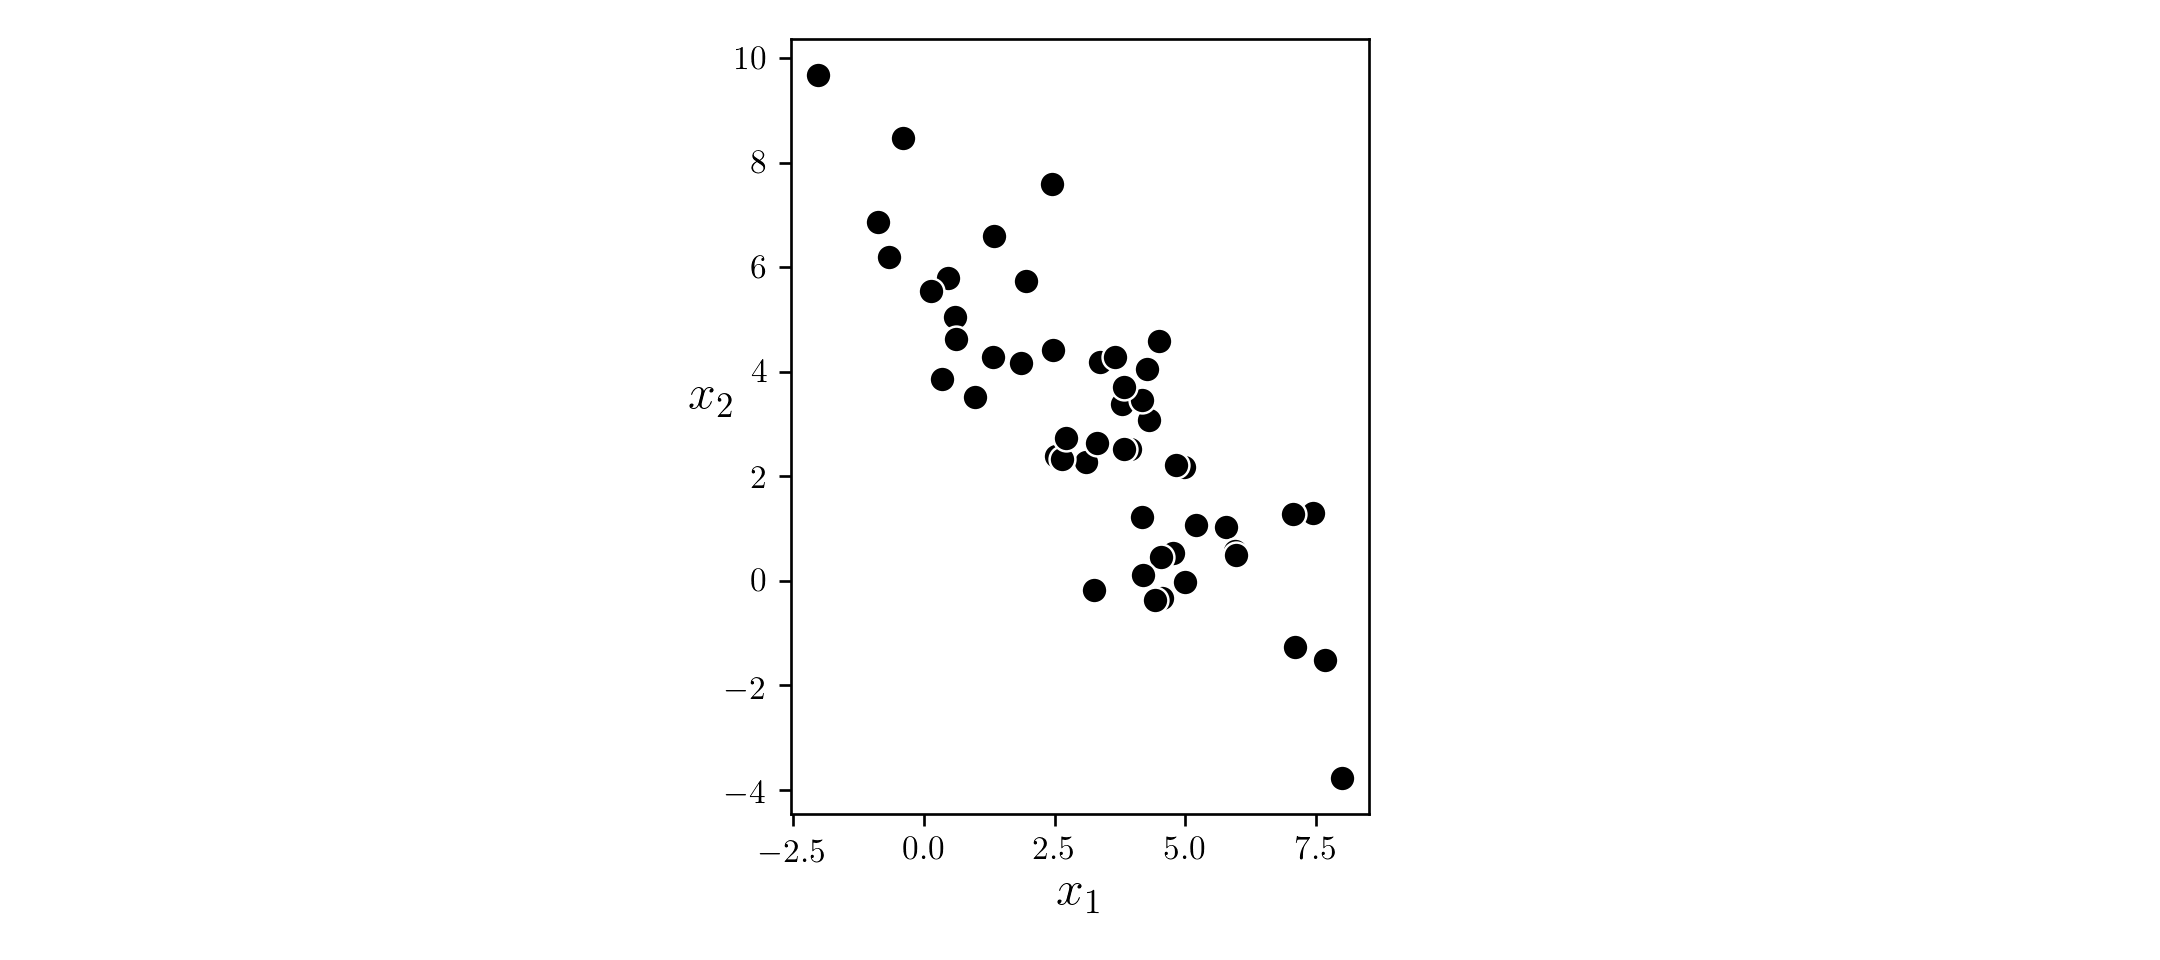

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import data
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X_original[0,:],X_original[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')

Now we can implement the least squares cost function in equation (4).  To stay consistent with our style for implementing cost functions, we will input package the weights for $\mathbf{C}$ and $\mathbf{W}$ in a single input list `w` as `w = [C,W]`.  Once inside the cost function we can then simply strip off each matrix of weights and compute the cost function, as shown below in the implementation.

In [3]:
# an implementation of the least squares cost function for PCA
# here the weight matrices are loaded in a single list w = [C,W]
def least_squares(w):  
    # strip off C and W parameters
    C = w[0]
    W = w[1]
    
    # compute the least squares cost
    cost = np.sum((np.dot(C,W) - X)**2)
    return cost/float(X.shape[1])

Now make a run of $100$ gradient descent steps with a fixed steplength parameter $\alpha = 1$ for all steps in order to minimize the PCA Least Squares cost function implemented above.  Here we use the implementation of gradient descent given in Section 6.4, which we employ via a backend file.

With our gradient descent run complete we can plot the associated cost function history to make sure the method has converged sufficiently for our settings.  We do this below.

<IPython.core.display.Javascript object>


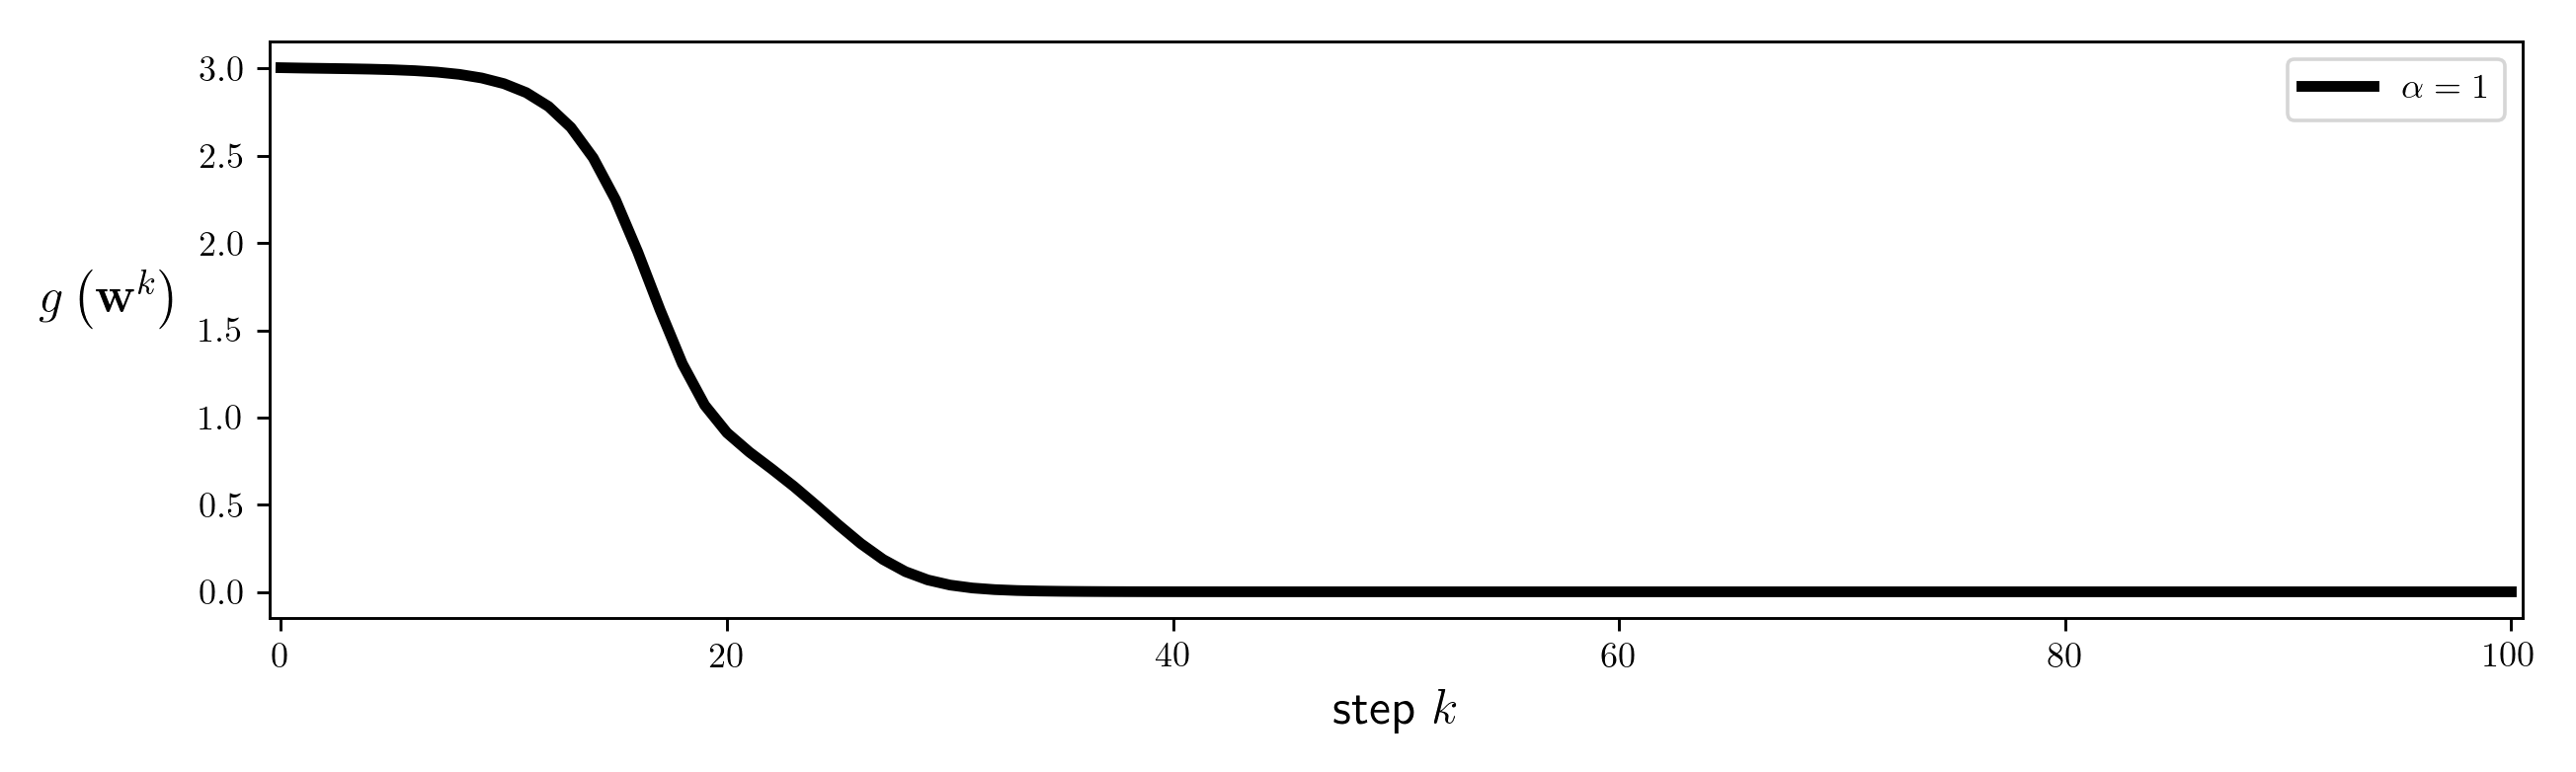

In [62]:
# This code cell will not be shown in the HTML version of this notebook
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 100; alpha_choice = 10**(0);

# initialize both matrices of parameters
num_elements = 2; scale = 0.1;
C = scale*np.random.randn(X.shape[0],num_elements)
W = scale*np.random.randn(num_elements,X.shape[1])
w = [C,W]

# run gradient descent
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

In the left panel below we plot our best recovered basis (from the final step of the run above) along with the original data.  Here the two basis vectors - shown as red arrows - are essentially two random vectors in the plane.  Essentially any two random vectors will do here since they will span the entire space of the data, giving a perfect representation.  In the right panel we plot the encoded version of the data - i.e., the associated learned weight vectors $\mathbf{w}_p$ (see the previous Section if this nomenclature is unfamiliar).

<IPython.core.display.Javascript object>


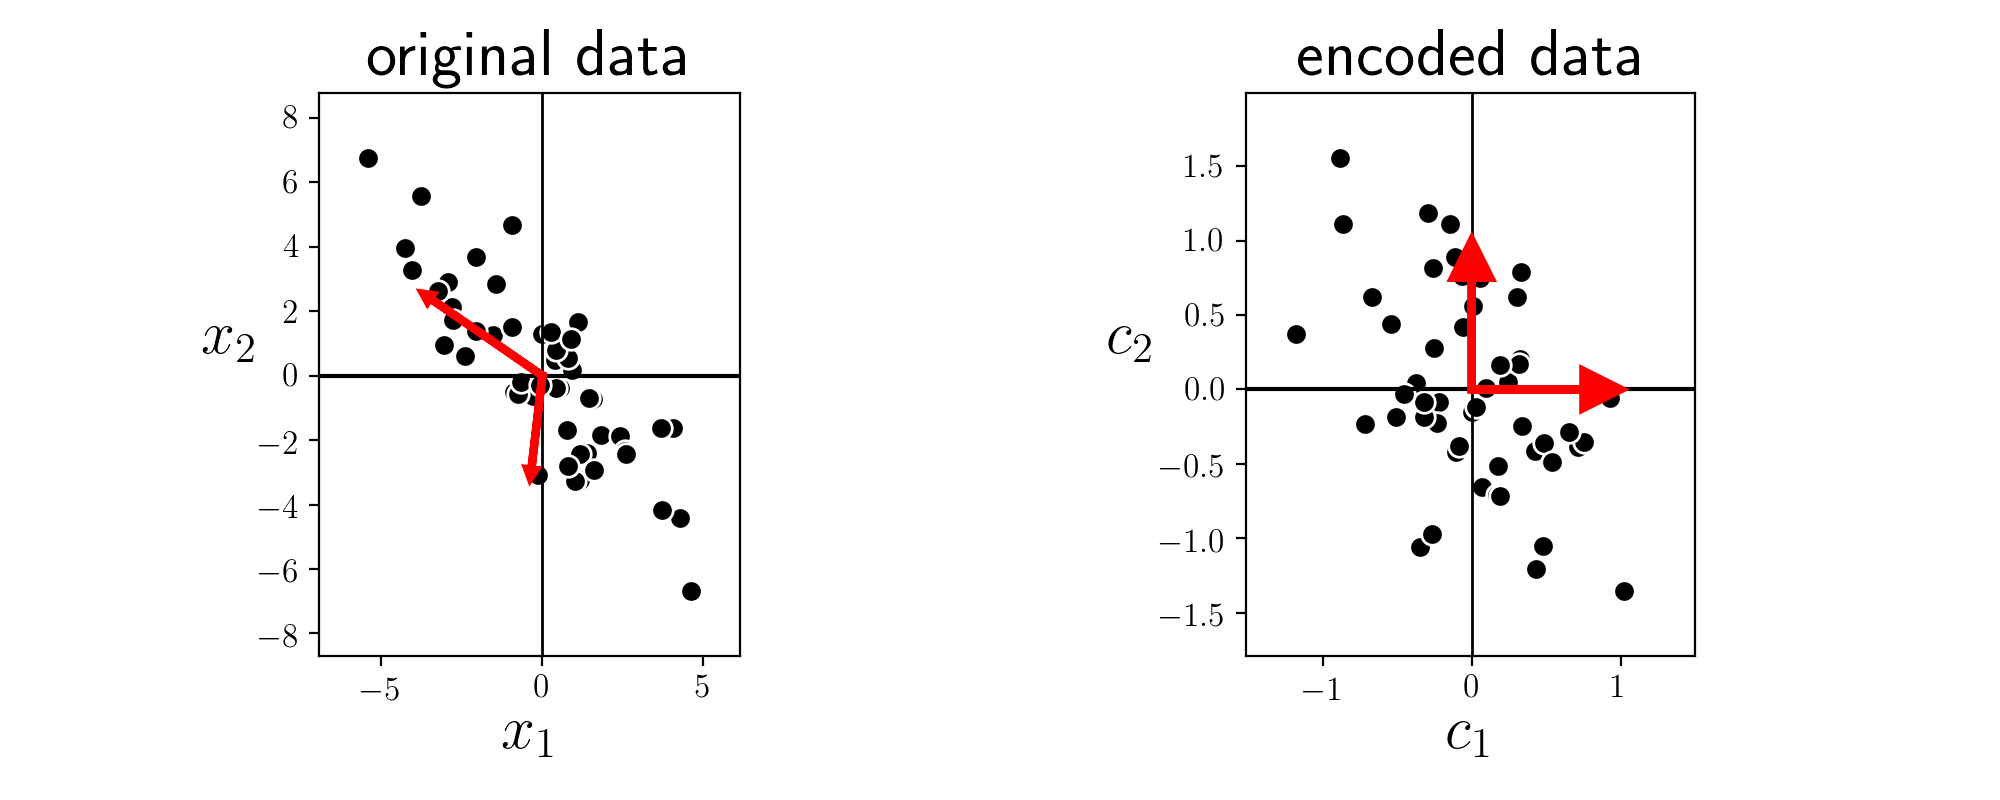

In [43]:
# This code cell will not be shown in the HTML version of this notebook
# plot the original data with determined basis, and the encoded version
# of the data (i.e., the associated weight vectors)
C = weight_history[-1][0]
unsuplib.span_animation.perfect_visualize_transform_static(C,X=X)

To empirically validate (at least to some degree) the notion that proper minimization will - in this instance - recover essentially any two random vectors, we show the results of three more runs of gradient descent using the same parameters as above but with a random initialization in each instance.  We plot the best recovered basis in each instance afterwards, and as we can see each instance differs considerably from the others (recovering two linearly independent vectors in each case).

<IPython.core.display.Javascript object>


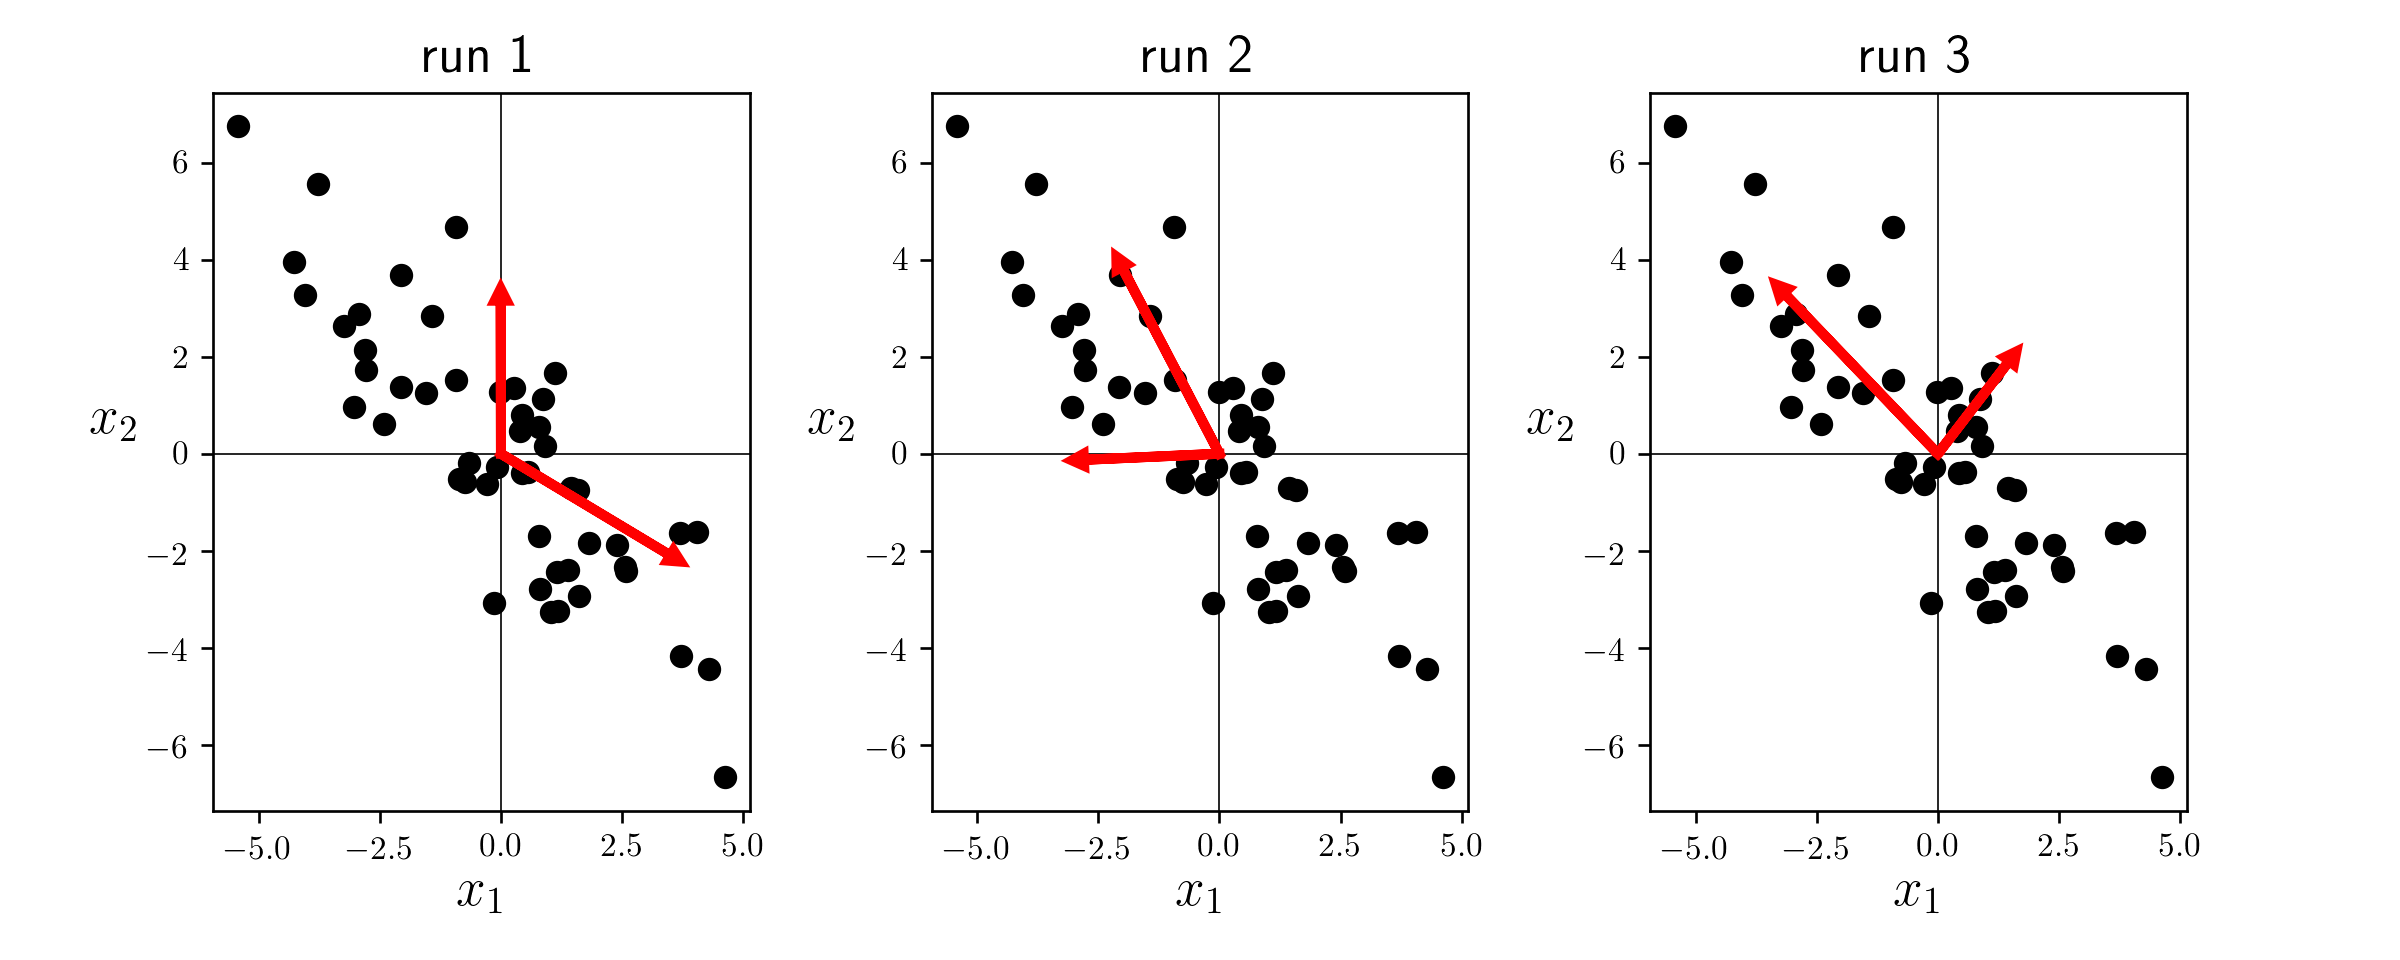

In [12]:
# This code cell will not be shown in the HTML version of this notebook
# make three runs of gradient descent to minimie the autoencoder, and plot the resulting
# principal components found
best_bases = []
num_runs = 3
max_its = 100; alpha_choice = 10**(0);
num_elements = 2; scale = 0.1; g = least_squares;
for i in range(num_runs):
    # generate random initial matrices
    C = scale*np.random.randn(X.shape[0],num_elements)
    W = scale*np.random.randn(num_elements,X.shape[1])
    w = [C,W]

    # run gradient descent to minimize the PCA least squares cost
    weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

    # pluck out best weights
    ind = np.argmin(cost_history)
    C_best = weight_history[ind][0]
    best_bases.append(C_best)
    
# plot all three autoencoder solutions
unsuplib.autoencoder_demos.visual_comparison(X,best_bases)

#### <span style="color:#a50e3e;">Example 2: </span> Learning a proper subspace via gradient descent

In this example we use gradient descent to minimize the PCA Least Squares cost in order to learn the best two-dimensional subspace representation of an $N=3$ dimensional dataset consisting of $100$ points.   We load in the dataset below and mean-center it.

Now we make a run of $100$ gradient descent steps with a fixed steplength value of $\alpha = 1$ for each step.  With these settings gradient descent converges very well.  Notice: to learn $2$ basis elements we initialize $\mathbf{C}$ as a random $3 \times 2 $ matrix (i.e., it will have only two spanning vectors), and likewise initialize each weight vector to have only two entries.

In [45]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
X_original = np.loadtxt(datapath + '3d_span_data.csv',delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 100; alpha_choice = 10**(0);

# set up initialization
scale = 0.1;
C = scale*np.random.randn(3,2)
W = scale*np.random.randn(2,100)
w = [C,W]

# run gradient descent
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

With this run complete we can plot our two learned spanning vectors $\mathbf{c}_1$ and $\mathbf{c}_2$, the two-dimensional subspace it spans, etc.,  We do this below.  The left panel shows the original data (as gray dots), learned spanning vectors (shown as red arrows), and corresponding subspace colored in light red.  This is the very best two-dimensional subspace representation for the input data.  In the middle panel we show the corresponding learned weight vectors / encodings $\mathbf{w}_p$ of the original input $\mathbf{x}_p$ in the space spanned by the recovered spanning vectors.  In the right panel we show the original data space again and the decoded data points (gray dots with red borders) - i.e., the projection of each datapoint onto the space spanned by our learned basis.  As detailed in the previous Section the decoded version of the $p^{th}$ point $\mathbf{x}_p$ is computed as $\mathbf{C}\mathbf{w}_p$, where $\mathbf{C}$ and $\mathbf{w}_p$ are the fully learned basis and encoding for the $p^{th}$ point. 

<IPython.core.display.Javascript object>


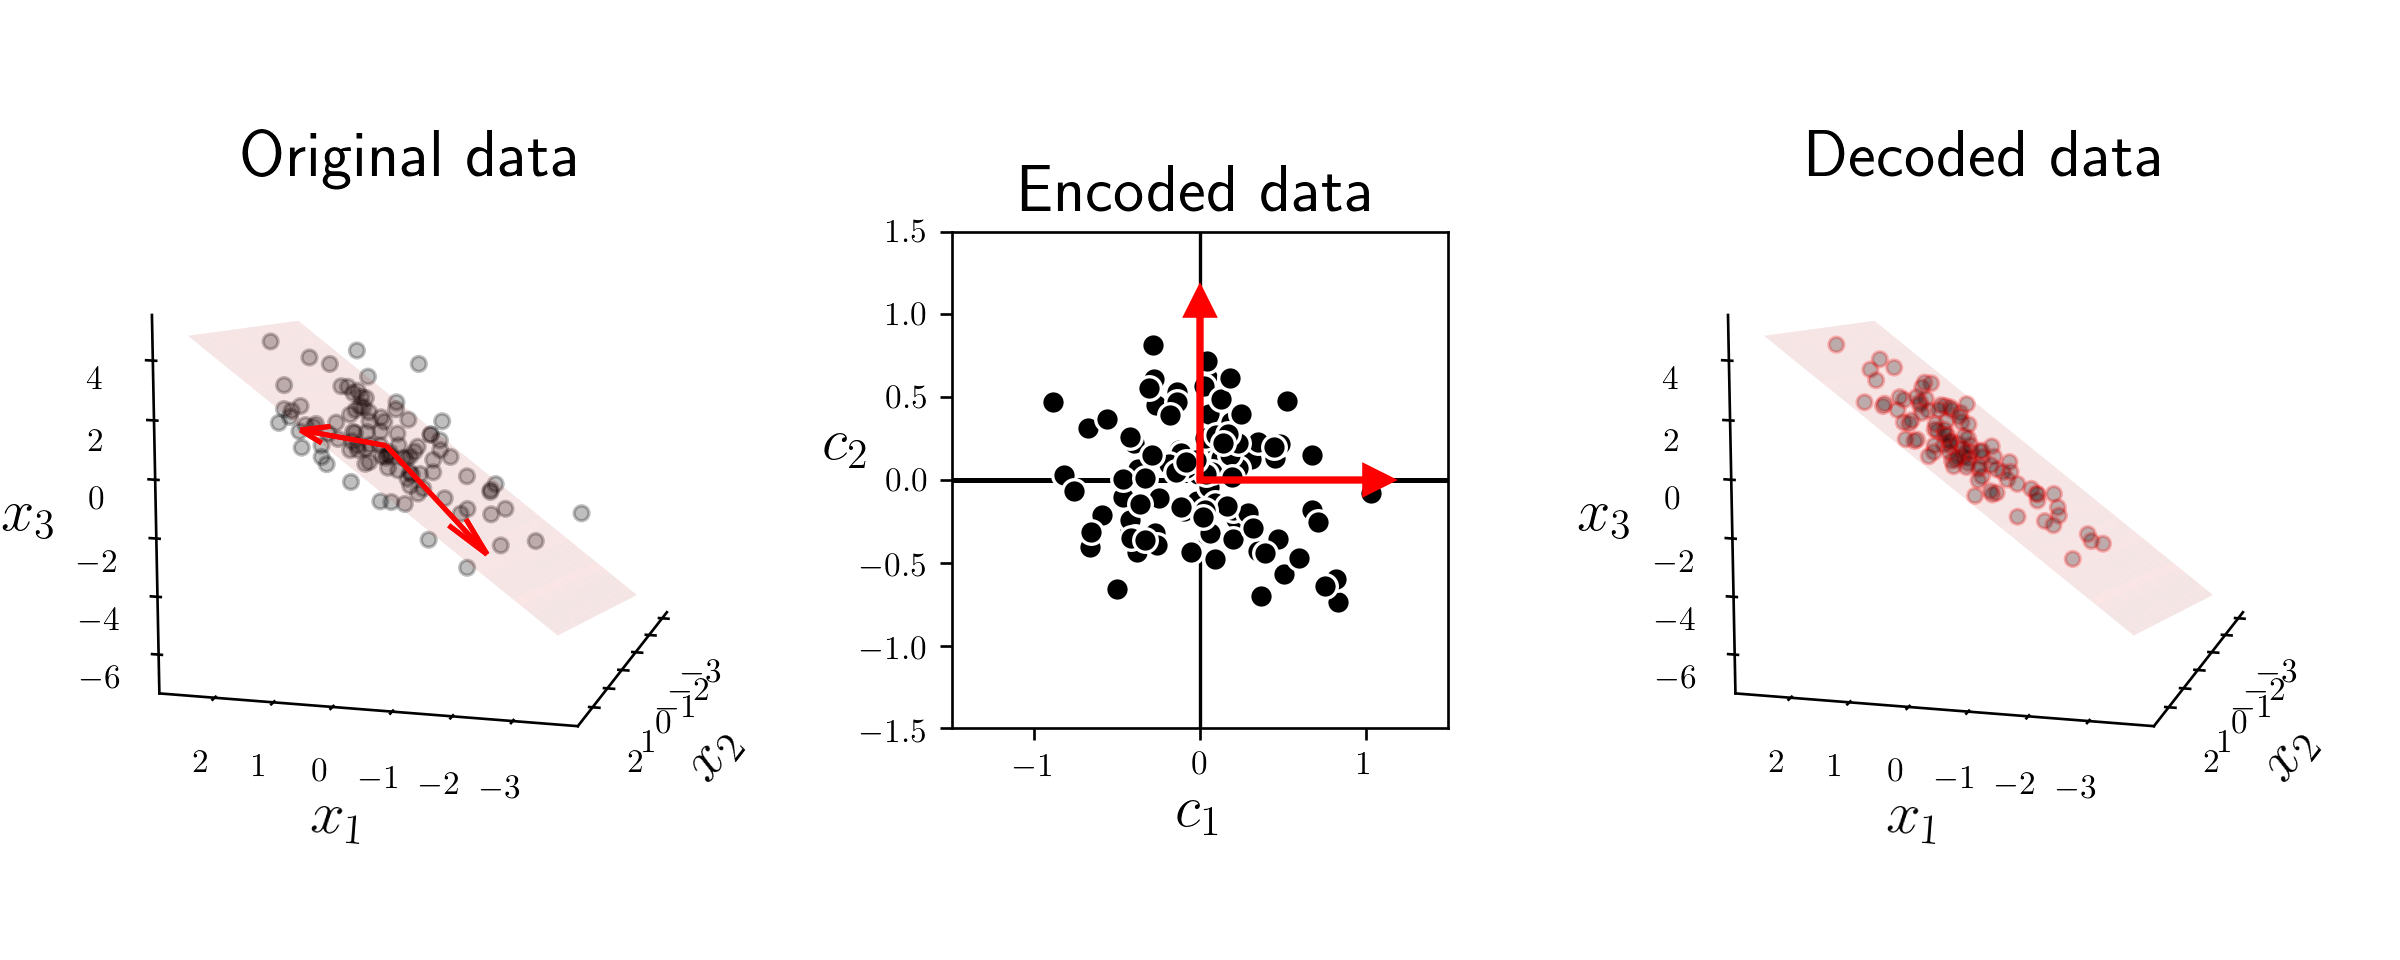

In [46]:
# This code cell will not be shown in the HTML version of this notebook
# produce visuals
C = weight_history[-1][0]
view = [15,105]
unsuplib.PCA_demos.project_data_from_3d_to_2d(X,C,view)

## 9.2.2 Learning orthogonal spanning sets via the PCA Autoencoder

In the previous Section we examined the special case of an *orthogonal basis* or spanning set, one whose members are perpendicular to one another and have unit length.  This set of conditions can be written mathematically *for any orthogonal basis* as

\begin{array}
\
\mathbf{c}_n^T\mathbf{c}_m^{\,} = 0 \\
\left \Vert \mathbf{c}_n \right \Vert_2^2 = 1 \,\,\,\,\text{for}\,\,n=1...K
\end{array}

or all together in a single line using matrix notation as 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}
\end{equation}


where $\mathbf{C}$ is the basis matrix built by stacking the spanning vectors columnwise and $\mathbf{I}_{K\times K}$ is the $K \times K$ identity matrix (i.e., all ones along the diagonal, zeros everywhere else).  

Importantly we saw how the use of **any** fixed orthogonal basis significantly simplifies the computation of weight / encoding vectors $\mathbf{w}_p$.  More specifically we saw how the typical computation for the weight / encoding vector $\mathbf{w}_p$ of the $p^{th}$ point $\mathbf{x}_p$ using any *fixed* basis $\mathbf{C}$ of $K$ vectors simplifies from the typical linear system of equations (which must be solved for a standard fixed basis)

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,}\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

to the considerably simpler set of computations (since indeed $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}$)

\begin{equation}
\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p      \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1...P.
\end{equation} 

Now, notice one consequence of this update formula.  Since it holds for *any orthogonal matrix*, if we have such a basis we can readily plug in the solution to each $\mathbf{w}_p$ right back into each summand of the original Least Squares cost function in equation (2) giving

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2 = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

The formula on the right is interesting in that - again under the assumption that $\mathbf{C}$ is orthogonal - the corresponding Least Squares cost function does not contain weight / encoding vectors *explicitly* (but *implicitly* as the computations $\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$).  This version of the Least Squares cost - where the given basis is assumed orthogonal - can also be derived geometrically by looking at how each data point is represented over such a basis - as illustrated in the figure below.

(Note: if $\mathbf{C}$ has $N$ entries (and so is size $N \times N$) then it is the case that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T = \mathbf{I}_{N\times N}$ and each summand above simplifies to $\left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2 = \left \Vert \mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2 = 0$.  However note that if $K < N$ then $\mathbf{C}^T\mathbf{C}^{\,} \neq \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T$ and so such simplification does not occur.  Indeed in this case $\mathbf{C}^T\mathbf{C}^{\,}$ is a $K \times K$ matrix, while $\mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T$ is $N\times N$.)

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/autoencoder_geometry.png' width="95%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> 
The geometry of projecting a point $\mathbf{x}$ onto a basis of orthogonal vectors, shown when using $K = 1$ vectors in the left panel and $K = 2$ in the right.  (left panel) The general projection (or decoding) of a point $\mathbf{x}$ onto a single basis vector $\mathbf{c}$ simplifies from $\mathbf{c}\frac{\mathbf{c}^T\mathbf{x}}{\mathbf{c}^T\mathbf{c}}$ to just $\mathbf{c}\mathbf{c}^T\mathbf{x}$ when $\mathbf{c}$ is orthogonal (also discussed in Section 11.1.3). This decoded point - living in the space spanned by $\mathbf{c}$ - is the point on $\mathbf{c}$ that lies closest to $\mathbf{x}$ and so minimizes the distance $\left\Vert \mathbf{c}\mathbf{c}^T\mathbf{x} - \mathbf{x}\right\Vert_2$.  (right panel)  The analogous scenario with two orthogonal vectors.  The projection / decoding of a point $\mathbf{x}$ over two orthogonal basis vectors $\mathbf{C} = 
\begin{bmatrix}
\vert \,\,\,\,\, \vert \,\,\,  \\
\mathbf{c}_1 \,\,\, \mathbf{c}_2 \\
\vert \,\,\,\,\, \vert \,\,\, 
\end{bmatrix}
$
is similarly given as $\mathbf{C}\mathbf{C}^T\mathbf{x}$.  This point - in the space spanned by the two basis vectors - is the point closest to $\mathbf{x}$ of those living in this plane, and so minimizes the error $\left\Vert \mathbf{C}\mathbf{C}^T\mathbf{x} - \mathbf{x}\right\Vert_2$.  Note we only square this error in the autoencoder cost so that we can more easily differentiate it and apply e.g., gradient descent to its minimization.
  </em>  </figcaption> 
</figure>

Now if we turn the tables and return to main problem in this Section of *learning* proper bases, notice that if we constrain our search to only *orthogonal* matrices $\mathbf{C}$ where $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}$ then - just as with the cost function above - the PCA Least Squares cost function in equation (3) likewise simplifies to 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2 = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}


This is interesting because - so long as we enforce the orthogonality constraint - the cost function above is no longer a function of the weight / encoding vectors, and is *only a function of $\mathbf{C}$*.  Therefore we can write it as 

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

This simplified version of the PCA Least Squares cost function is often referred to as the **autoencoder**.  Why does it go by this name?  Because when we minimize the original PCA Least Squares cost we find both the best encoding (provided by the learned weights $\mathbf{w}_p$) and decoding (provided by the projection via the learned basis / encoding product $\mathbf{C}\mathbf{w}_p$) for a given dataset.  In this form of the cost function we still do this - but here learn the encoding / decoding of each $\mathbf{x}_p$ in terms of *itself*.  In particular the *encoding* of the $p^{th}$ point $\mathbf{x}_p$ will be - when the cost is entirely tuned and we have an ideal basis $\mathbf{C}$ - expressed in this way as

\begin{equation}
\left(\text{encoding}\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p
\end{equation}

and the decoding of this point likewise as 

\begin{equation}
\,\,\, \left(\text{decoding}\right) \,\,\,\,\,\, \mathbf{C}_{\,}^T\mathbf{w}_p  = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p. \,
\end{equation}

We can see too that in minimizing the autoencoder we aim to make each summand $\left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2$ as small as possible.  So in minimizing each of these squared error terms we are *regressing* every data point against itself in the hopes of forcing the approximations

\begin{equation}
\mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p \approx \mathbf{x}_p    \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1,...,P
\end{equation}

to be as close to equality as possible.  

This is true even if we do not strictly enforce the orthogonality constraint as well.  Indeed one can show - as we do in the appendix of this Section - that *global minima of the autoencoder are always orthogonal matrices* irregardless if we strictly enforce orthogonality ourselves.  This makes the need for an explicit orthogonality constraint somewhat redundant and so more often than not we simply *disregard the explicit orthogonality constraint* and minimize the autoencoder cost function above directly using e.g., gradient descent, since the basis recovered via optimization will tend to be (approximately) orthogonal anyway if we have optimized correctly.

#### <span style="color:#a50e3e;">Example 3: </span> Learning complete orthogonal bases via the autoencoder and gradient descent

When learning $K = N$ basis vectors via minimizing the autoencoder cost function we can be confident that any recovered basis is indeed orthogonal since global minima of the cost function in this case clearly occur when $\mathbf{C}^{\,}\mathbf{C}^T = \mathbf{I}_{N\times N}$, providing the cost value $g\left(\mathbf{C}\right) = 0$.

In this example we illustrate this fact using the $N=2$ dimensional dataset from example 1 above.  Using three runs of gradient descent - each with a different random initializatio - we minimize the autoencoder over this dataset.  Afterwards we plot each learned basis on top of the original data, in each case we can visually confirm that the recovered basis is indeed orthogonal.

Below we given a `Python` implementation of the autoencoder cost function in equation (10), which for organization purposes we have split into two modules: our typical `model` function which here produces the computation $\mathbf{C}^{\,}\mathbf{C}^{T}\mathbf{x}_p$ for each input, and the autoencoder cost function that computes the Least Squares error against the data.

In [75]:
# a quick mockup of the autoencoder model
def model(x,C):    
    # perform encoding 
    W = np.dot(C.T,X)
    
    # perform decoding 
    a = np.dot(C,W)
    return a

# an implementation of the least squares cost function for linear regression
def autoencoder(C):
    cost = np.sum((model(X,C) - X)**2)
    return cost/float(X.shape[1])

Below we import the data, center it, and then make three runs of gradient descent to minimize the autoencoder over the dataset (using a random initialization in each instance).

<IPython.core.display.Javascript object>


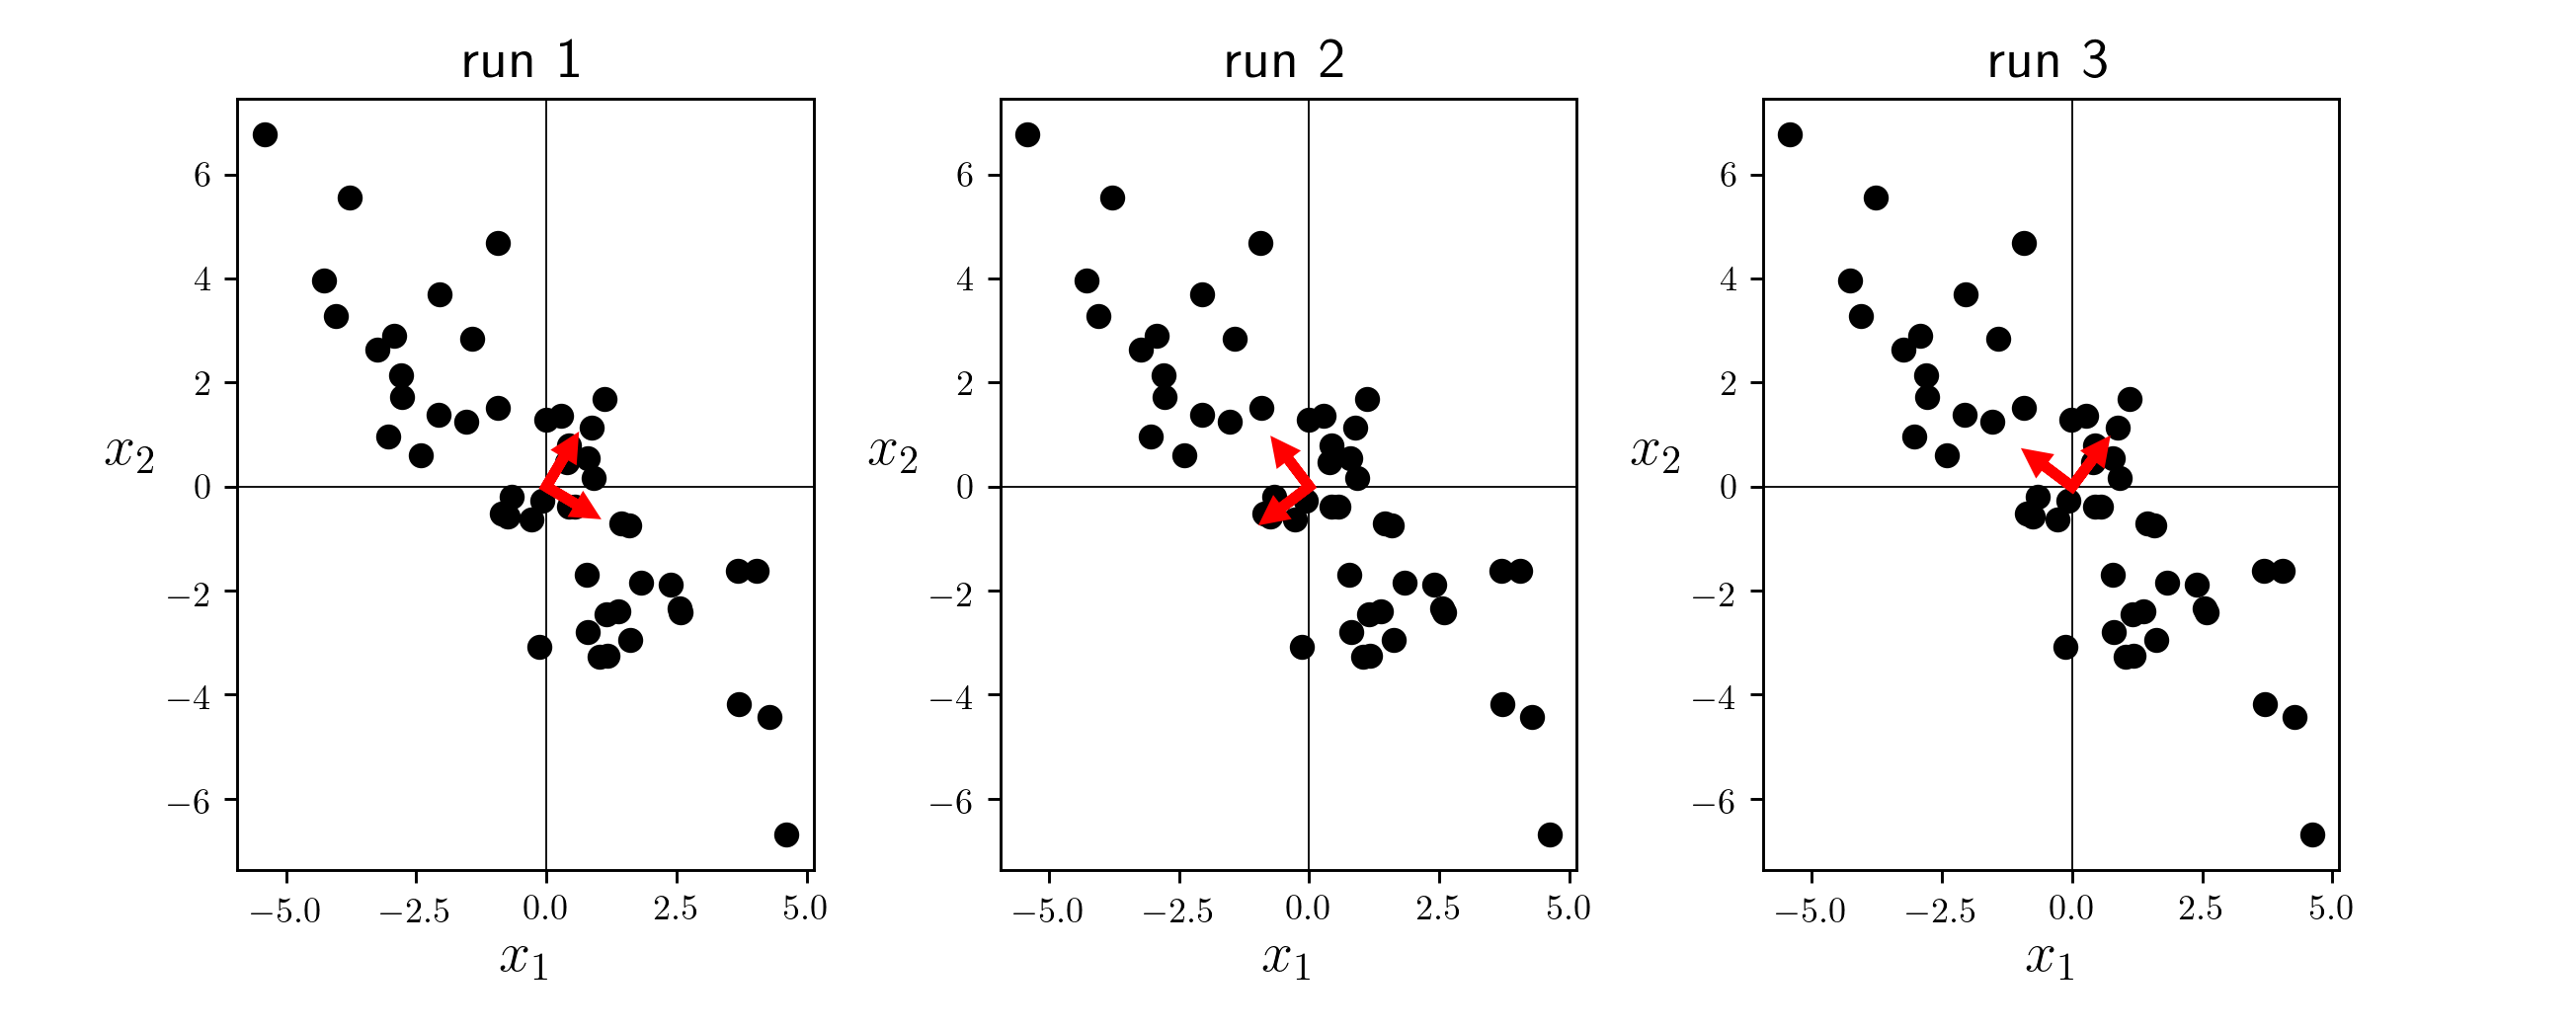

In [83]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# make three runs of gradient descent to minimie the autoencoder, and plot the resulting
# principal components found
best_weights = []
num_runs = 3
for i in range(num_runs):
    # tune pca least squares cost
    g = autoencoder; alpha_choice = 10**(-2); max_its = 1000; C = 0.1*np.random.randn(2,2);
    weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,C)

    # pluck out best weights
    ind = np.argmin(cost_history)
    w_best = weight_history[ind]
    best_weights.append(w_best)
    
# plot all three autoencoder solutions
unsuplib.autoencoder_demos.visual_comparison(X,best_weights)

#### <span style="color:#a50e3e;">Example 4: </span> Learning an incomplete orthogonal bases via the autoencoder and gradient descent

Now we use our standard gradient descent optimizer to tune the parameters of the autoencoder for an $N = 2$ dimensional dataset, which has already been centered.  Here we will seek out only a single learned basis vector, and examine its final encoded and decoded versions visually.  

Below we plot a number of pictures resulting from minimizing the autoencoder.  Here we show the original data along with the learned basis element shown in the left panel, the encoded data in the middle panel i.e., the value of each learned weight $\mathbf{c}^T\mathbf{x}_p = w_p$, and the decoded data  $\mathbf{c}\mathbf{c}^T\mathbf{x}_p = \mathbf{c}w_p$ in the right panel.  In the right panel we also show the linear subspace (the span of the single basis vector $\mathbf{c}$ found) in red.

<IPython.core.display.Javascript object>


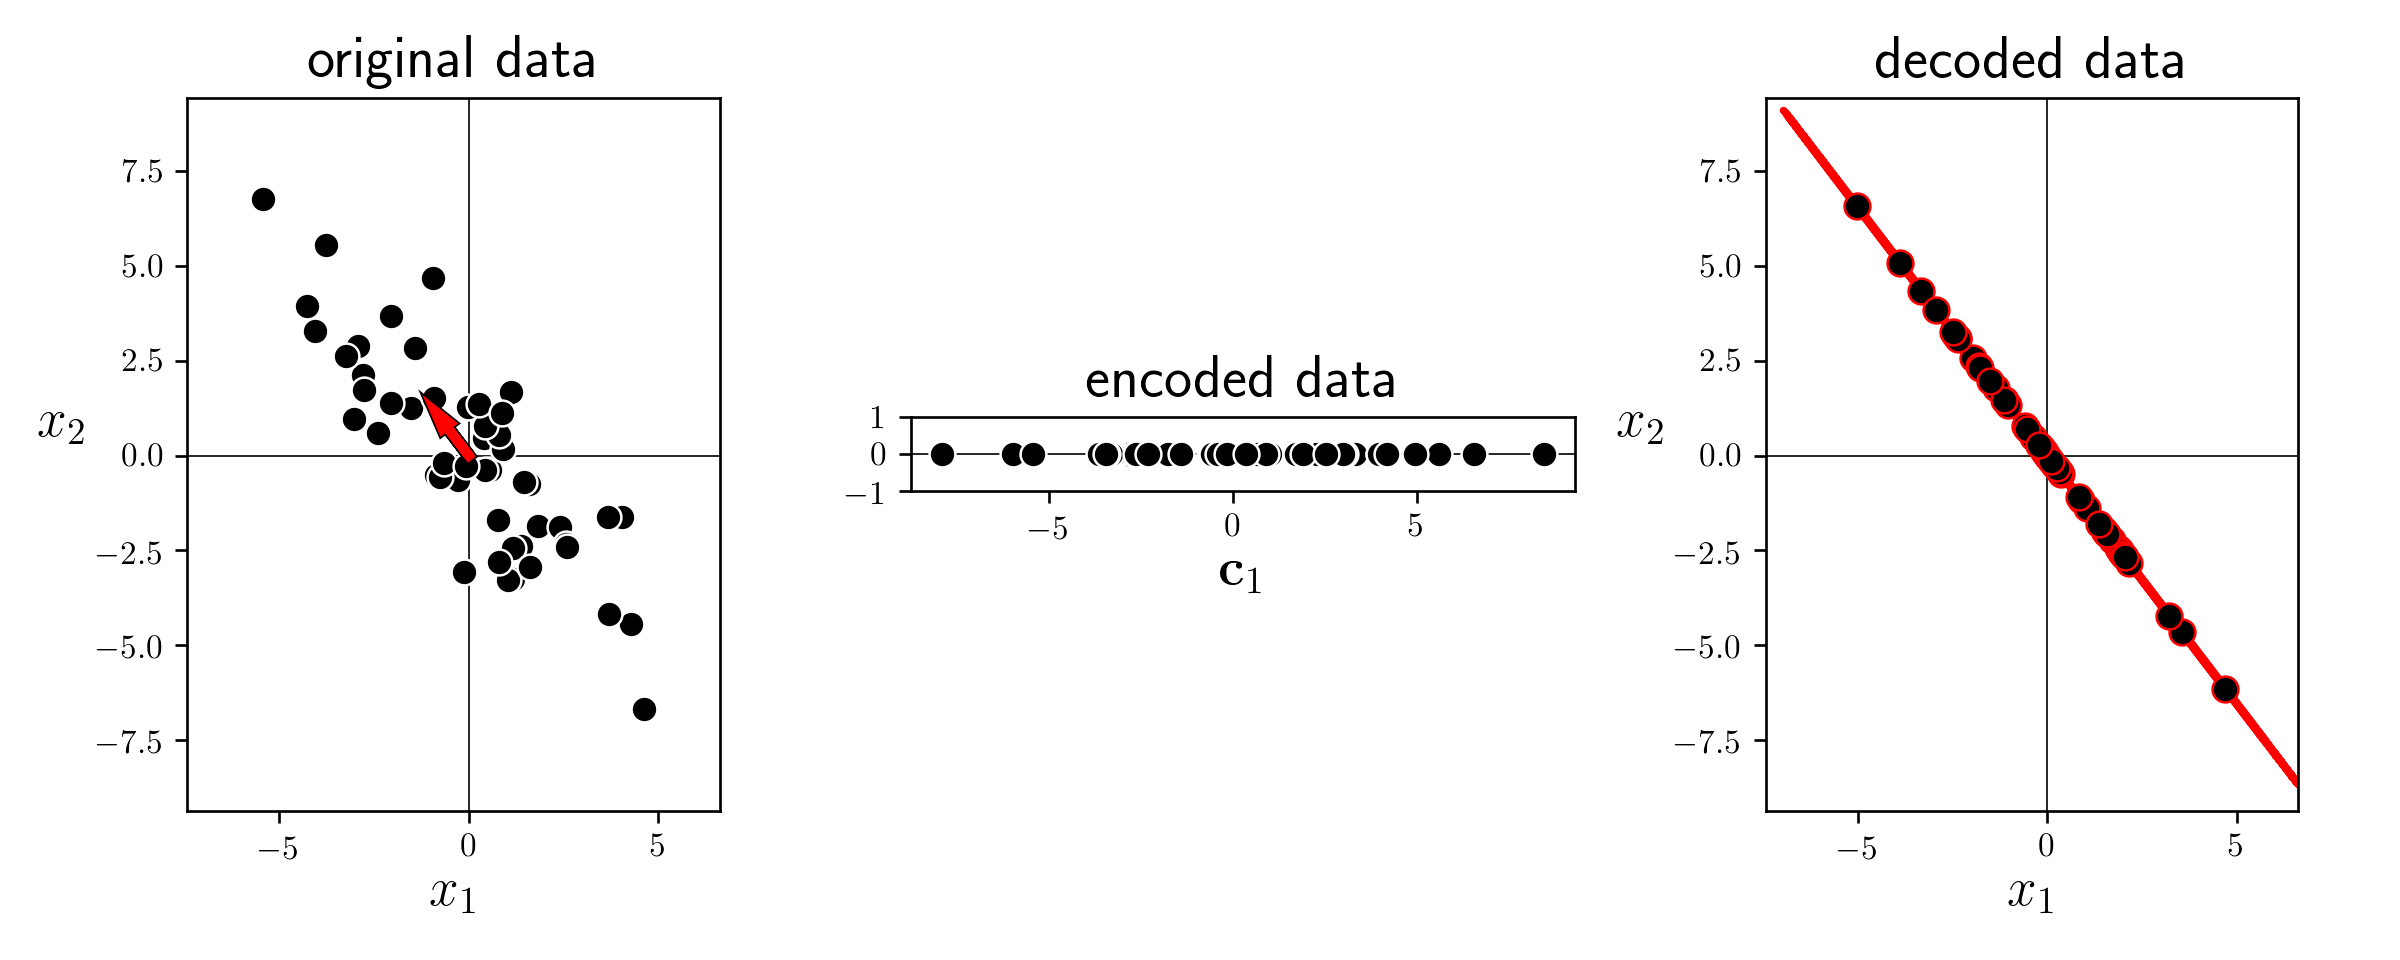

In [99]:
# This code cell will not be shown in the HTML version of this notebook
# load in a dataset to learn a PCA basis for via the autoencoder
x = np.loadtxt(datapath + '2d_span_data_centered.csv',delimiter=',')

# tune the autoencoder via gradient descent
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000; C = 0.1*np.random.randn(2,1);
C = np.array([[-3.5],[3.5]])
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,C)

# display results of the autoencoder
unsuplib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,show_pc = True,scale = 150,encode_label = r'$\mathbf{c}_1$',projmap = False)

Interestingly, examining the contour plot of the autoencoder in this instance we can see that it has two global minima - located precisely at the location of the *first principal component* of the dataset - a term we define in the subsection that follows.  We show the contour plot of the autoencoder in the left panel below, and this contour plot along with the steps of gradient descent plotted on top (colored green to red, when the run starts to when it halts) in the right panel below.

<IPython.core.display.Javascript object>


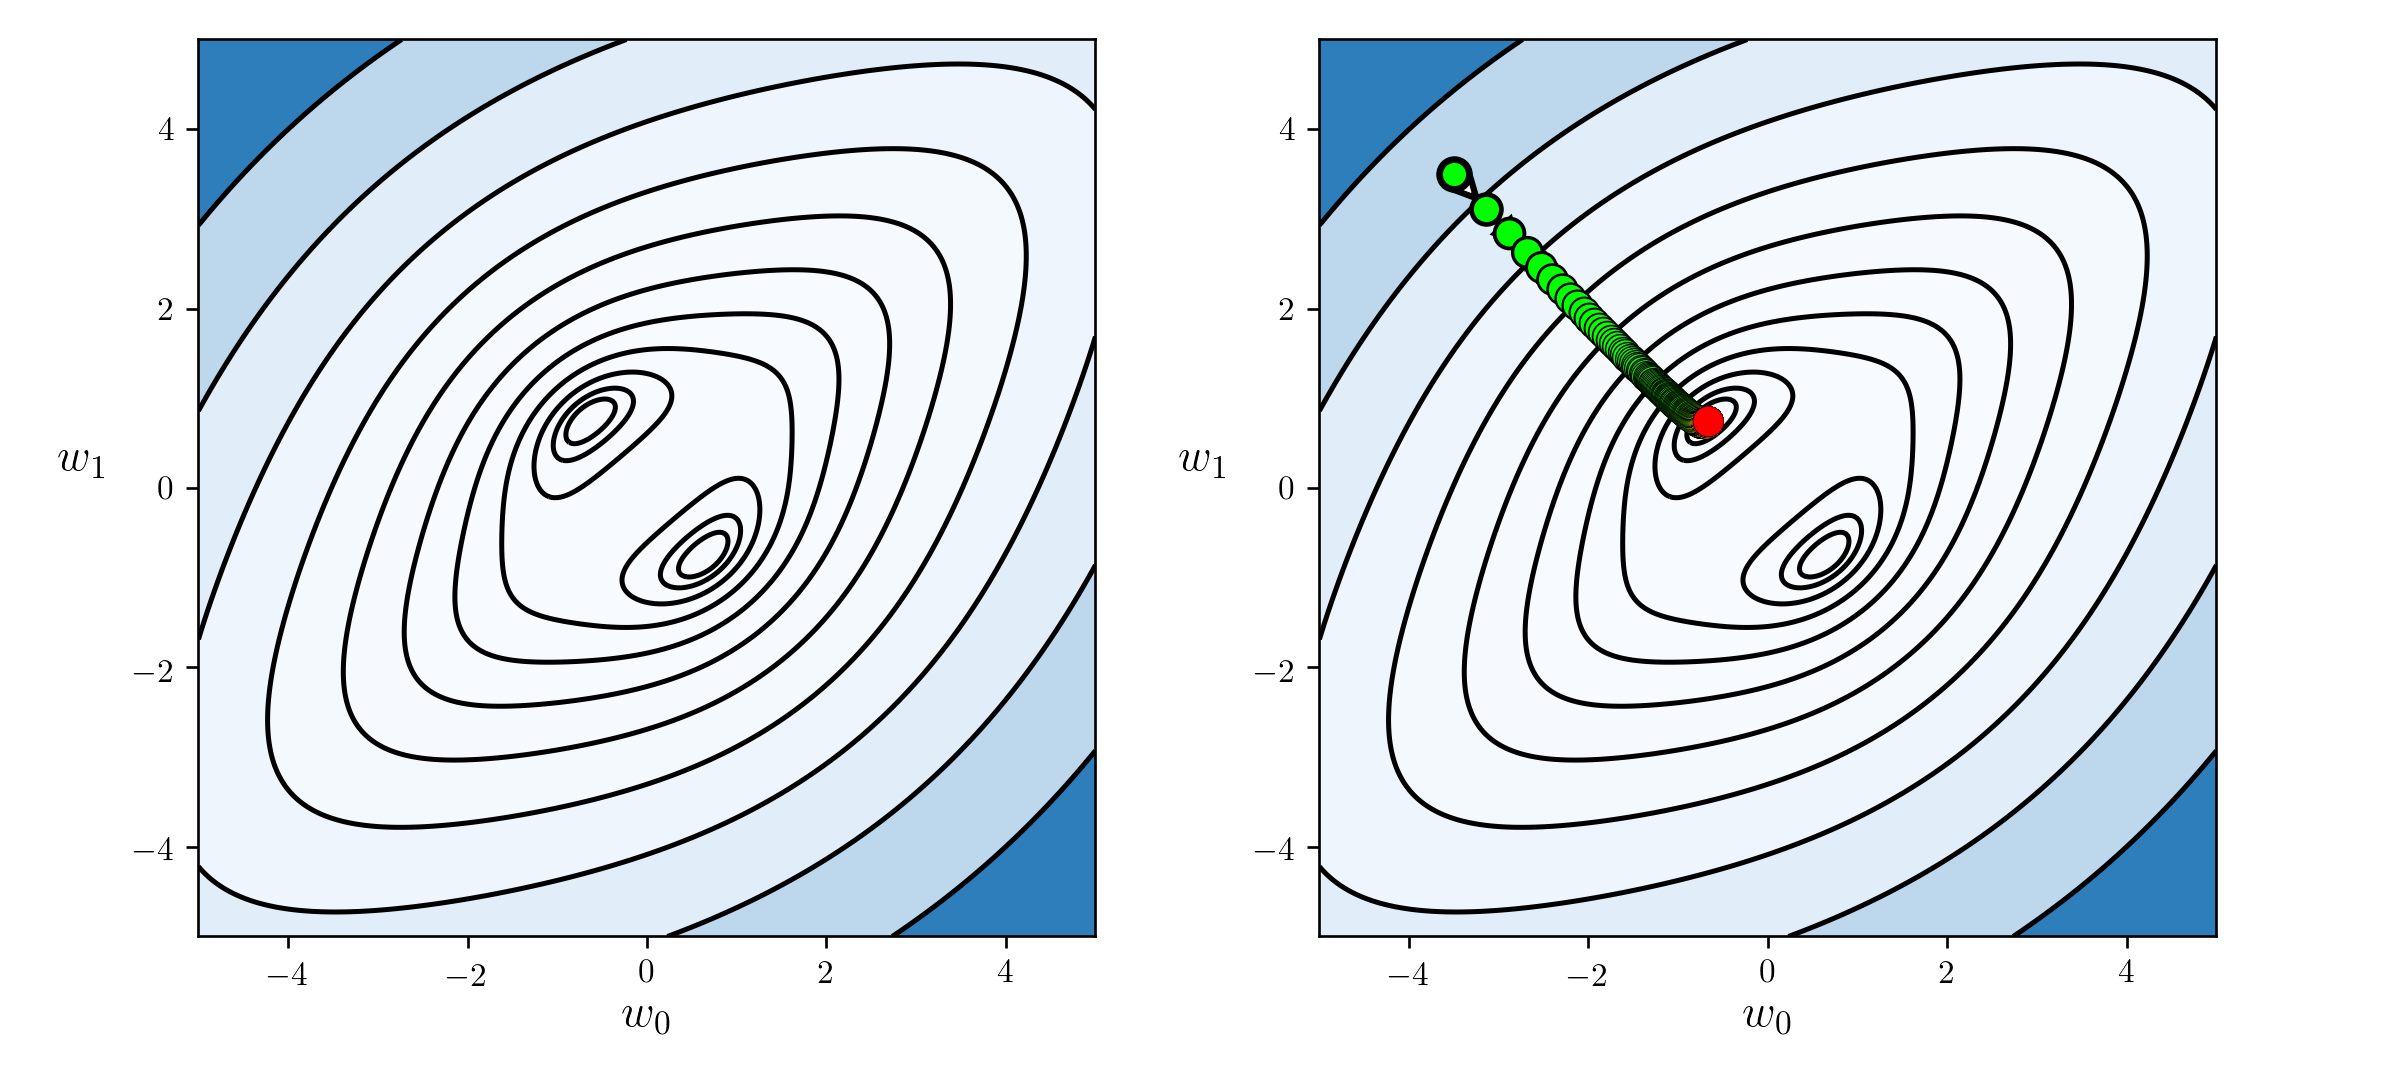

In [101]:
# This code cell will not be shown in the HTML version of this notebook
# show run on contour plot
static_plotter.two_input_contour_plot(autoencoder,weight_history,xmin = -5,xmax = 5,ymin = -5,ymax = 5,num_contours = 11,show_original = True)

## 9.2.3 The classic PCA minimizer of the Autoencoder cost function

In t his Section we discuss the classic *principal components* learned basis for a dataset, which is a somewhat remarkable formula: it is a closed form solution or minimizer (i.e., one we can write out algebraically) of the autoencoder cost function.  Very rarely in practice can we calculate minima of a cost function like the autoencoder 'by hand' - which is why we instinctively turn to a local method like gradient descent when confronted with a cost function to minimize - so the fact that we can do this is indeed quite special. 

However it is the solution itself - an orthogonal basis whose members point in the *orthogonal directions of variance of a dataset* (as illustrated in the Figure below) - that provide a special form-fitting 'skeleton' to any dataset that no other solution to the autoencoder can provide (see the figure below).  The elements of this basis are so special they are given the formal name *principal components* - and indeed the method of learning a basis we have been studying this Section is named after them: Principal Component Analysis.  This special solution of the autoencoder cost is by far the most common one used in practice, and is used commonly applications ranging from visual data analysis (when using $K < N$ elements) and as an advanced form of input normalization (called PCA-sphereing, which is detailed in the Section following this one).

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_classic.png' width="60%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> The classic orthogonal PCA minimizer of the autoencoder cost function.  The elements of this basis point in the orthogonal directions of variance of the dataset, that is the orthogonal directions in which the dataset is most spread out.  Here we show a prototypical two-dimensional example where the recovered bases elements $\mathbf{c}_1 = d_1\mathbf{v}_1$ and $\mathbf{c}_2 = d_2\mathbf{v}_2$ are - as we will see below - constructed from the eigenvalues / vectors of the data covariance matrix.
</em>  </figcaption> 
</figure>

We will not focus on the derivation of these principal components here - the interested reader can see a complete derivation in the Appendix of this Section - we will instead summarize and illustrate (with a `Python` implementation) how they are computed.  Denoting by $\mathbf{X}$ the *data matrix* - consisting of 

\begin{equation}
\mathbf{X} = 
\begin{bmatrix}
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert \\
\,\, \mathbf{x}_1 \,\,\, \mathbf{x}_2 \,\,\, \cdots \,\,\, \mathbf{x}_P \\
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert 
\end{bmatrix}
\end{equation}

the *principal component* basis can be computed (as a minimum of the autoencoder cost function) as the *eigenvectors* of the corresponding *correlation matrix* of this data

\begin{equation}
\text{covariance matrix of } \, \mathbf{X}: = \, \frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T
\end{equation}

Denoting the eigenvector/value decomposition of the covariance matrix 
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T$ is given as

\begin{equation}
\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T
\end{equation}

then above the orthonormal basis we recover is given precisely by the eigenvectors above, i.e., $\mathbf{C} = \mathbf{V}$.  Again, these are referred to in the jargon of machine learning as the *principal components* of the data.  Moreover, the variance in each (principal component) direction is given precisely by the corresponding eigenvalue in $\mathbf{D}$.

**A practical note:** in practice it is often helpful to slightly *regularize* a matrix prior to computing its eigenvalues/vectors to avoid natural numerical instability issues associated with their computation.  Here this means adding a small weighted identity $\lambda\mathbf{I}_{N\times N}$, where $\lambda \geq0$ is some small value (like e.g., $10^{-5}$), to the covariance matrix prior to computing its eigenvalues/vectors.  In short, in order to avoid computational trouble we typically compute principal components of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T  + \lambda \mathbf{I}_{N\times N}$ instead of the raw covariance matrix itself.

### PCA algorithm  (classic orthogonal solution) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,...,\mathbf{x}_P$ stacked column-wise into a $N\times P$ data matrix $\mathbf{X}$, regularization parameter $\lambda$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>compute</code> mean of dataset $\boldsymbol{\mu} = \frac{1}{P}\sum_{p=1}^P\mathbf{x}_p$ and center data as $\mathbf{x}_p \longleftarrow \mathbf{x}_p - \boldsymbol{\mu}$ for $p=1,...,P$ <br> 

<strong>3:</strong>&nbsp;&nbsp; <code>compute</code>  $\frac{1}{P}\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ (regularized correlation matrix)<br> 

<strong>4:</strong>&nbsp;&nbsp; <code>compute</code>
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T +\lambda \mathbf{I}_{N\times N}= \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$ (eigenvalue / vector decomposition of correlation matrix)
<br>

<strong>5:</strong>&nbsp; <strong>output:</strong> optimal principal components PCA basis $\mathbf{V}$ and weights $\hat{\mathbf{w}}_p^{\,} = \mathbf{V}^T\mathbf{x}_p^{\,}$ for $p=1,...,P$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

The ``Python`` cell below contains implementations of each fundamental idea here - data centering, principal component computation, and the PCA transformation.

In [103]:
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array, mean-centering
    and division by its standard deviation
    
    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    '''
    A function for computing the principal components of an input data matrix.  Both
    principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
    are returned
    '''
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.  
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

#### <span style="color:#a50e3e;">Example 5: </span>  A simple example learning a spanning set via Principal Component Analysis 

In this example we illustrate the PCA basis - and transformed feature space - using a two-dimensional dataset.  This example mirrors the second part of Example 1 above precisely, only here we learn a basis of two spanning vectors via PCA instead of picking two fixed ones.  In the left panel we plot the mean-centered data, along with its two principal components (pointing in the two orthogonal directions of greatest variance in the dataset).  We find these by stacking the mean-centered data column-wise into the matrix $\mathbf{X}$ and determining the eigenvalue / vector decomposition of $\frac{1}{P}\mathbf{X}^{,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$, as detailed above.  We provide just this sort of  functionality in the ``Python`` cell below.

In the right panel we show the *transformed feature space* - whose coordinate axes are now the eigenvectors $\mathbf{v}_1$ and $\mathbf{v}_2$.  Each point $\mathbf{x}_p$ in the left panel corresponds to the tuned weight vector $\mathbf{w}_p$ in the right panel.  Remember: because the PCA basis is orthonormal these weights are given precisely as $\mathbf{w}_p = \mathbf{C}^T_{\,}\mathbf{x}^{\,}_p = \mathbf{V}^T_{\,}\mathbf{x}^{\,}_p$.  Also notice: in the transformed feature space provided by the PCA basis the data has simply been rotated so that its two orthogonal directions of variance perfectly align with the horizontal / vertical axes of the space.  

<IPython.core.display.Javascript object>


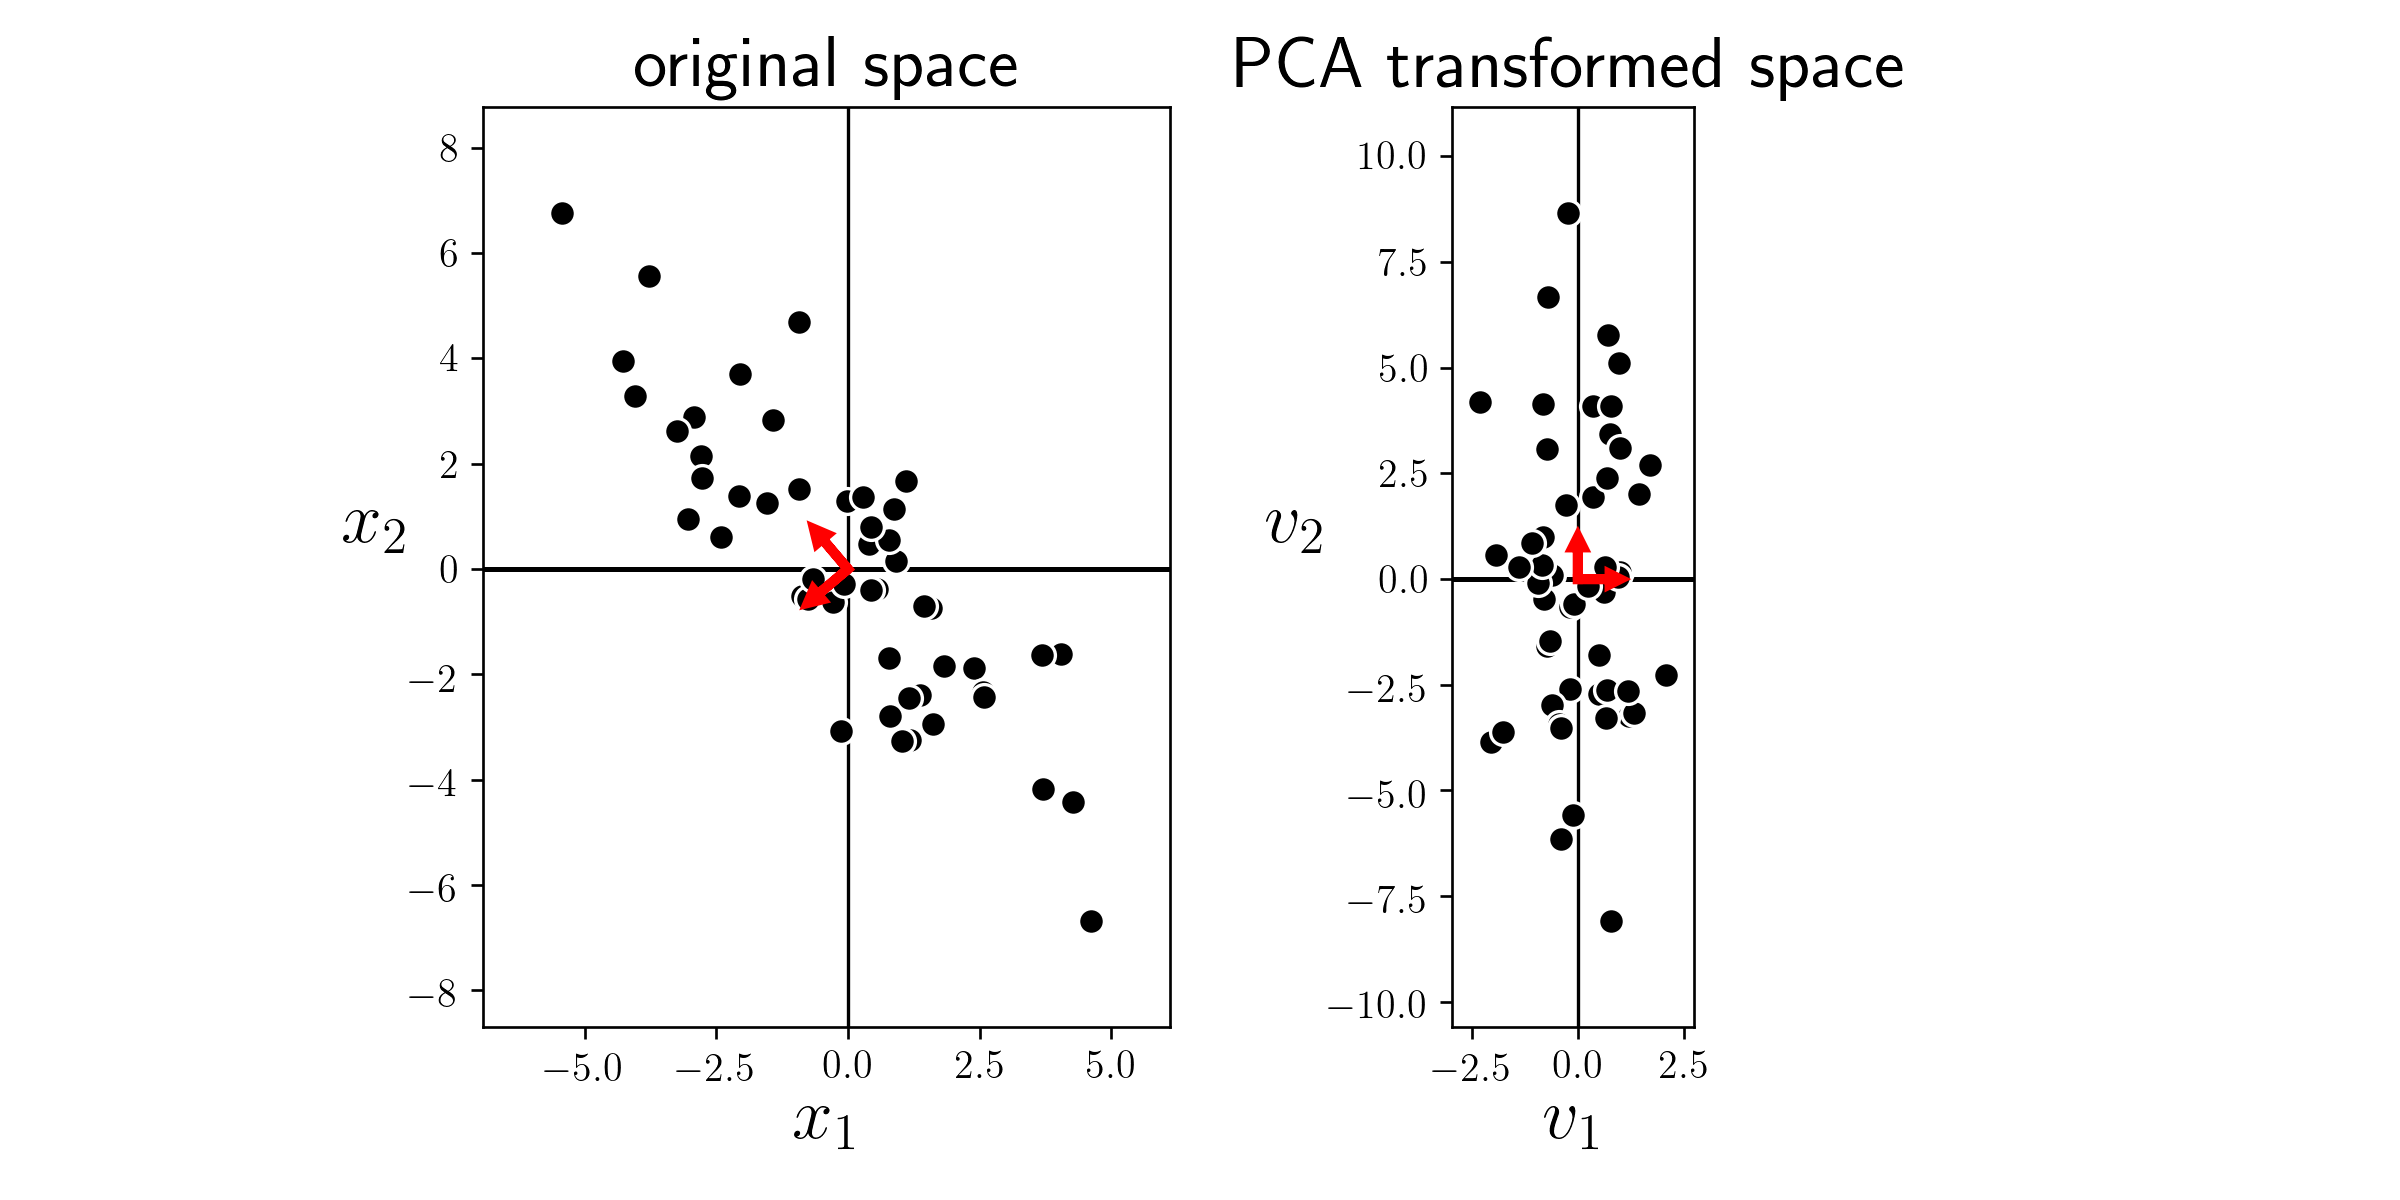

In [104]:
# load in dataset to perform PCA on, and mean-center
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,V = pca_transform_data(X)

# plot data in original and pca-transformed spaces
unsuplib.PCA_demos.pca_visualizer(X,W,V)

#### <span style="color:#a50e3e;">Example 6: </span>  Dimension reduction with the classic PCA basis

In this example we illustrate how the lassic PCA basis can be used to represent a three-dimensional dataset via its ideal two-dimensional linear subspace, using the first two principal components.  In the next cell we load in the dataset first shown in Example 3, compute the orthogonal PCA spanning set based on the eigenvectors of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$, and project the data onto the two-dimensional subspace spanned by the top two eigenvectors.  These top two eigenvectors and the subspace they span are shown in red in the left panel below, with the projected data in the subspace spanned by the top two eigenvectors are shown in the right panel.

<IPython.core.display.Javascript object>


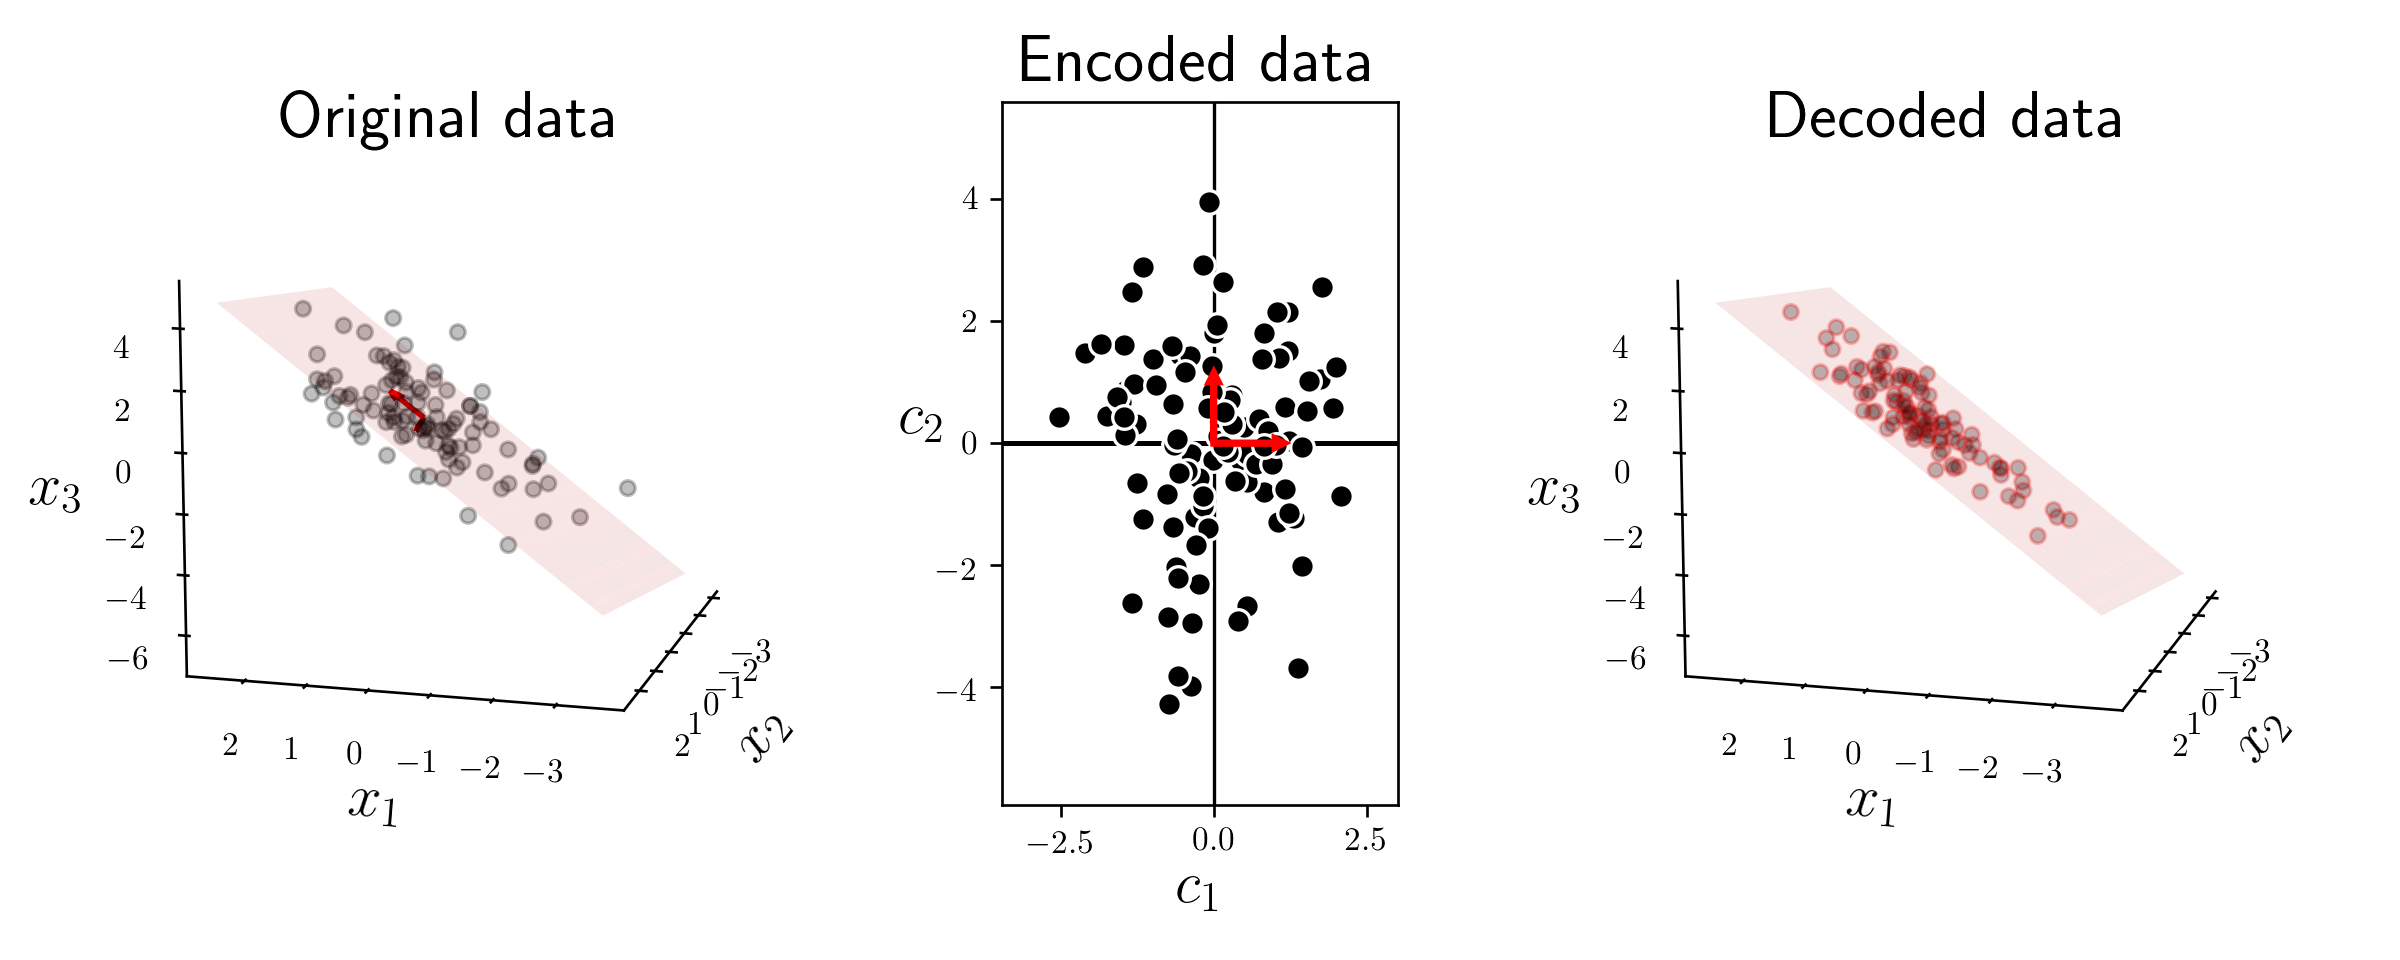

In [105]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '3d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the two-dimensional PCA transformation of dataset
W,C = pca_transform_data(X,num_components = 2)

# produce visuals
init = [15,105]
unsuplib.PCA_demos.project_data_from_3d_to_2d(X,C,view)

#### <span style="color:#a50e3e;">Example 7: </span> A warning about PCA dimension reduction and classification data

While PCA dimension reduction can technically be used for preprocessing data in a predictive modeling scenario - wherein the data is reduced in dimension in hopes of improving accuracy / computation time -  it can cause severe problems in the case of classification. In this Example we illustrate feature space dimension reduction via PCA on a simulated two-class dataset where the two classes are linearly separable. Because the ideal one-dimensional subspace in this instance runs parallel to the longer length of each class, projecting the complete dataset onto it completely destroys the separability. 

Because of this, while it is certainly common place to *sphere* classification data using PCA - as detailed in Example 6 - one needs to be extremely careful using PCA as a dimension reduction tool with classification.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_7.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 3:</strong> <em> (left) A toy classification dataset consisting of two linearly separable classes. The ideal subspace produced via PCA is shown in black. (right) Projecting the data onto this subspace (in other words reducing the feature space dimension via PCA) destroys completely the original separability of the data.  </em>  </figcaption> 
</figure>

## 9.2.5 Formal derivations

### Formal proof that the autoencoder has orthogonal global minima 

Here we show that the autoencoder cost is minimized when the $N \times K$ matrix $\mathbf{C}$ is orthogonal.  To do this recall the following important facts (discussed in our review Chapter on linear algebra)


- The matrix $\mathbf{C}\mathbf{C}^T$ is an *outer product matrix* and so has *all nonnegative* eigenvalues


- If $d_k$ is a nonnegative eigenvalue of $\mathbf{C}\mathbf{C}^T$, then $\sqrt{d_k }$ is an associated singular value of $\mathbf{C}$



- A matrix is orthogonal if and only if its singular values are all equal to $+1$

With these facts in hand we can now state the aim of our argument.  Below we will show that the autoencoder

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

is minimized when the matrix $\mathbf{C}\mathbf{C}^T$  is orthogonal by showing that it achieves its minimum value when this matrix has all non-zero eigenvalues equal to $+1$. 

To do this we first re-write each summand by substituting in the eigenvector/value diagonalization for $\mathbf{C}\mathbf{C}^T$ 
as $\mathbf{C}\mathbf{C}^T = \mathbf{V}\mathbf{D}\mathbf{V}^T$ where $\mathbf{V}$ is an $N\times K$ orthogonal matrix of eigenvectors and $\mathbf{D}$ is a $K\times K$ diagonal matrix with all real eigenvalues along its diagonal,, and then following through with the squaring operation.  This gives

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  = \left \Vert \mathbf{V}\mathbf{D}\mathbf{V}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  =  \mathbf{x}_p^T \mathbf{V} \mathbf{D}\mathbf{D} \mathbf{V}^T \mathbf{x}_p   -2\mathbf{x}_p^T  \mathbf{V}\mathbf{D}\mathbf{V}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p
\end{equation}

where note we have used the fact that $\mathbf{V}$ is orthogonal.  Now, denoting $\mathbf{A}^2 = \mathbf{A}\mathbf{A}$ for any square matrix $\mathbf{A}$ and setting $\mathbf{q}_p = \mathbf{V}\mathbf{x}_p$ (introducing $\mathbf{I}_{N\times N} = \mathbf{V}^T\mathbf{V}$ into the third term right of the final equality above) then we can drastically simplify the above to

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  = \mathbf{q}_p^T \mathbf{D}\mathbf{D} \mathbf{q}_p   -2\mathbf{q}_p^T \mathbf{D} \mathbf{q}_p + \mathbf{q}_p^T \mathbf{q}_p = \mathbf{q}_p^T \left(\mathbf{D}^2 - 2\mathbf{D} + \mathbf{I}_{K\times K}\right)\mathbf{q}_p =  \mathbf{q}_p^T \left(\mathbf{D} - \mathbf{I}_{K\times K}\right)^2\mathbf{q}_p 
\end{equation}

Now let us take a moment to reflect on the expression above.  Our aim is to try and determine when the *sum* of such expressions

\begin{equation}
g\left(\mathbf{C}\right) = \sum_{p=1}^P \mathbf{q}_p^T \left(\mathbf{D} - \mathbf{I}_{K\times K}\right)^2\mathbf{q}_p 
\end{equation}

attains its minimum.  Note that since both $\mathbf{D}$ and $\mathbf{I}_{K\times K}$ are diagonal matrices, the matrix $\left(\mathbf{D} - \mathbf{I}_{K\times K}\right)^2$ too is diagonal (regardless of $\mathbf{D}$ with all nonnegative entries along its diagonal.  The autoencoder - irregardless of what form we write it in - is bounded below by $0$ - i.e., this is the smallest possible value the cost function can take.  

Now studying the form of the autoencoder we have come to above we can see that we can indeed achieve $g\left(\mathbf{C}\right) = 0$ is $\mathbf{D} = \mathbf{I}_{K\times K}$ or in other words when the matrix $\mathbf{C}\mathbf{C}^T$ has all non-zero eigenvalues equal to $+1$.  In such an instance this means that the matrix $\mathbf{C}$ has all *singular* values equal to $\sqrt{+1} = +1$ and so then $\mathbf{C}$ is indeed orthogonal.  

Therefore we have shown that the autoencoder is minimized only at orthogonal matrices $\mathbf{C}$.

### Formal derivation of the classic PCA solution to the autoencoder

From the formal proof provided above, we know that the minimizers of the autoencoder cost function are all orthogonal.  Therefore the classic (orthogonal) PCA solution we compute below is indeed a global minimizer of the autoencoder.

To begin the derivation of the classic *principal components* solution to the autoencoder all we must do is examine one summand of the autoencoder cost function, under the assumption that $\mathbf{C}$ is orthogonal.  Expanding the of the $p^{th}$ summand we have

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  =  \mathbf{x}_p^T \mathbf{C}^T \mathbf{C}\mathbf{C} \mathbf{C}^T \mathbf{x}_p   -2\mathbf{x}_p^T \mathbf{C}\mathbf{C}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p
\end{equation}

and then using our assumption that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$ we can see that it may be re-written equivalently as

\begin{equation}
 = -\mathbf{x}_p^T \mathbf{C}\mathbf{C}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p = -\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 + \left \Vert\mathbf{x}_p\right \Vert_2^2.
\end{equation}

Since our aim is to *minimize* the summation of terms taking the form of the above, and the data point $\mathbf{x}_p$ is fixed and does not include the variable $\mathbf{C}$ we are minimizing with respect to, minimizing the original summand on the left is equivalent to minimizing *only the first term* $-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2$ on the right hand side.  Summing up these terms, the $p^{th}$ of which can be written decomposed over each individual basis element we aim to learn as

\begin{equation}
-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 = -\sum_{n=1}^N \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2,
\end{equation}

gives us the following cost function (that is equivalent to the autoencoder under our assumption of orthogonality) to minimize for our ideal orthogonal basis

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{p=1}^P \sum_{n=1}^K  \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Studying this reduced form of our autoencoder cost function we can see that it *decomposes completely over the basis vectors $\mathbf{c}_n$*, i.e., there are no terms where $\mathbf{c}_i$ and $\mathbf{c}_j$ interact when $i\neq j$.  This means - practically speaking - that we can optimize our orthogonal basis *one element at a time*.  Reversing the order of the summands above we can isolate each individual basis element over the entire dataset, writing above equivalently as 

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{n=1}^K \sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Now we can think about minimizing our cost function one basis element at a time.  Beginning with $\mathbf{c}_1$ we first isolate only those relevant terms above, which consists of: $-\frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,}\right)^2$.    Since there is a minus sign out front of this summation, this is the same as *maximizing* its negation which we denote as

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Since our basis is constrained to be orthogonal the basis element $\mathbf{c}_1$ in particular is constrained to have unit-length.  Statistically speaking, the above measures the *sample variance of the dataset in the direction defined by $\mathbf{c}_1$*.  Note: this quantity is precisely the sample variance because our data is assumed to have been *mean-centered*.  Since we aim to maximize this quantity we can phrase our optimization in purely sample statistical terms as well: we aim to recover the a form of the basis vector $\mathbf{c}_1$ that points in the maximum direction of variance in the dataset.  

To determine the maximum value of the function above / determine the direction of maximum sample variance in the data we can rewrite the formula above by stacking the data points $\mathbf{x}_p$ column-wise - forming the $N\times P$ matrix $\mathbf{X}$ - giving the equivalent formula in 

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\mathbf{c}_1^T \mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \mathbf{c}_1^{\,} = \mathbf{c}_1^T\left(\frac{1}{P}\mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_1^{\,}.
\end{equation}

Written in this form the above takes the form of a so-called *Rayleigh Quotient* (see [example 9 of our post on optimality conditions](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html)) whose maximum can is expressible algebraically in closed form based on the [eigenvalue / eigenvector decomposition](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Linear_Algebra/Part_2_eigenvalues_and_eigenvectors.html) of the matrix $\mathbf{X}^{\,}\mathbf{X}^T$ (in the middle term) or likewise the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ (in the term on the right).  Because the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ can be interpreted statistically as the *covariance matrix* of the data it is more common to use the particular algebraic arrangement on the right.

So, denoting denoting $\mathbf{v}_1$ and $d_1$ the eigenvector and largest eigenvalue of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ the maximum of the above occurs when $\mathbf{c}_1 = \mathbf{v}_1$, where $h\left(\mathbf{v}_1\right) = d_1$ - which is also the variance in this direction.  Remember: this direction $\mathbf{v}_1$ points in the largest direction of variance in the dataset.  In the jargon of machine learning $\mathbf{v}_1$ is referred to as the *first principal component* of the data, hence the name *Principal Component Analysis*.

With our first basis vector in hand, we can move on to determine the second element of our ideal orthogonal spanning set.  Plucking out the relevant terms from equation (37) and following the same thought process we went through above results in the familiar looking function

\begin{equation}
h\left(\mathbf{c}_2\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_2^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

that we aim to maximize in order to recover our second basis vector.  This formula has the same sort of statistical interpretation as the analogous version of the first basis vector had above - here again it calculates the variance of the data in the direction of $\mathbf{c}_2$.  Since our aim here is to maximize - given that $\mathbf{c}_1$ has already been resolved and that $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$ due to our orthogonal assumption - the statistical interpretation here is that we are aiming to find the *second* largest orthogonal direction of sample variance in the data.

This formula can also be written in compact vector-matrix form as $h\left(\mathbf{c}_2\right) = \mathbf{c}_2^T \left(\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_2^{\,}$, and its maximum (given our restriction to an orthogonal basis implies that we must have $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$) is again expressible in closed form in terms of the eigenvalue / eigenvector decomposition of the covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$.  Here the same analysis leading to the proper form of $\mathbf{c}_1$ shows that the the maximum of the above occurs when $\mathbf{c}_2 = \mathbf{v}_2$ the eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its second largest eigenvalue $d_2$, and the variance in this direction is then $h\left(\mathbf{v}_2\right) = d_2$.  This ideal basis element / direction is referred to as the *second principal component of the data*.

More generally - following the same analysis for the $n^{th}$ member of our ideal orthonormal basis we look to maximize the familiar looking formula

\begin{equation}
h\left(\mathbf{c}_n\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

As with the first two cases above, the desire to maximize this quantity can be interpreted as the quest to uncover the $n^{th}$ orthogonal direction of sample variance in the data.  And following the same arguments, writing the above more compactly as $h\left(\mathbf{c}_n\right) = \mathbf{c}_n^T\left(\frac{1}{P} \mathbf{X}^{\,}\mathbf{X}^T_{\,}\right)\mathbf{c}_n^{\,}$ etc.,, we can show that it takes the form $\mathbf{c}_n = \mathbf{v}_n$, where $\mathbf{v}_n$ is the $n^{th}$ eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its $n^{th}$ largest eigenvalue $d_n$, and here the sample variance is expressible in terms of this eigenvalue $h\left(\mathbf{c}_n\right) = d_n$.  This is learned element / direction is referred to as the $n^{th}$ principal component of the data.

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.